# Comparative Analysis of Deep Learning Architectures for Earthquake Prediction

**AI7102: Introduction to Deep Learning - Project Proposal - Fall 2025**

**Team Members:** Mohamed Alrayssi, Majid Ibrahim, Hamdan Almehairbi, Mohammed Ibrahim Alblooshi

---
### Important Workflow

This project is split into three main parts:

1. **`prepare_dataset.py`**: Pre-processes all data and saves loaders.

2. **`experiment.py`**: Runs the optimizer comparison and generates `training_histories.json`.

3. **`analysis_notebook.ipynb`**: Loads `training_histories.json` to visualize results and analyze the best models.



To run this project correctly, you must first execute the experiment script from your terminal:



```bash

python experiment.py

```



After the script finishes, you can run the cells in this notebook to analyze the generated results.


## 1. Setup and Environment


In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm.auto import tqdm
from scipy.stats import ks_2samp

# Import our project modules
import utils
import data_loader
import models # To load model architecture for error analysis

# Configure plotting style
utils.setup_plotting_style()


Plotting style configured.


## 2. Data Loading and Exploratory Analysis (EDA)

In [121]:
DATA_PATH = 'data/train.csv' # Assumes train.csv is in a /data subfolder
train_df = data_loader.load_data(DATA_PATH, nrows=60_000_000)
display(train_df.head())


Loaded 60,000,000 rows from data/train.csv


acoustic_data  time_to_failure
0             12           1.4691
1              6           1.4691
2              8           1.4691
3              5           1.4691
4              8           1.4691

Visualizing a sample of the raw time-series data:


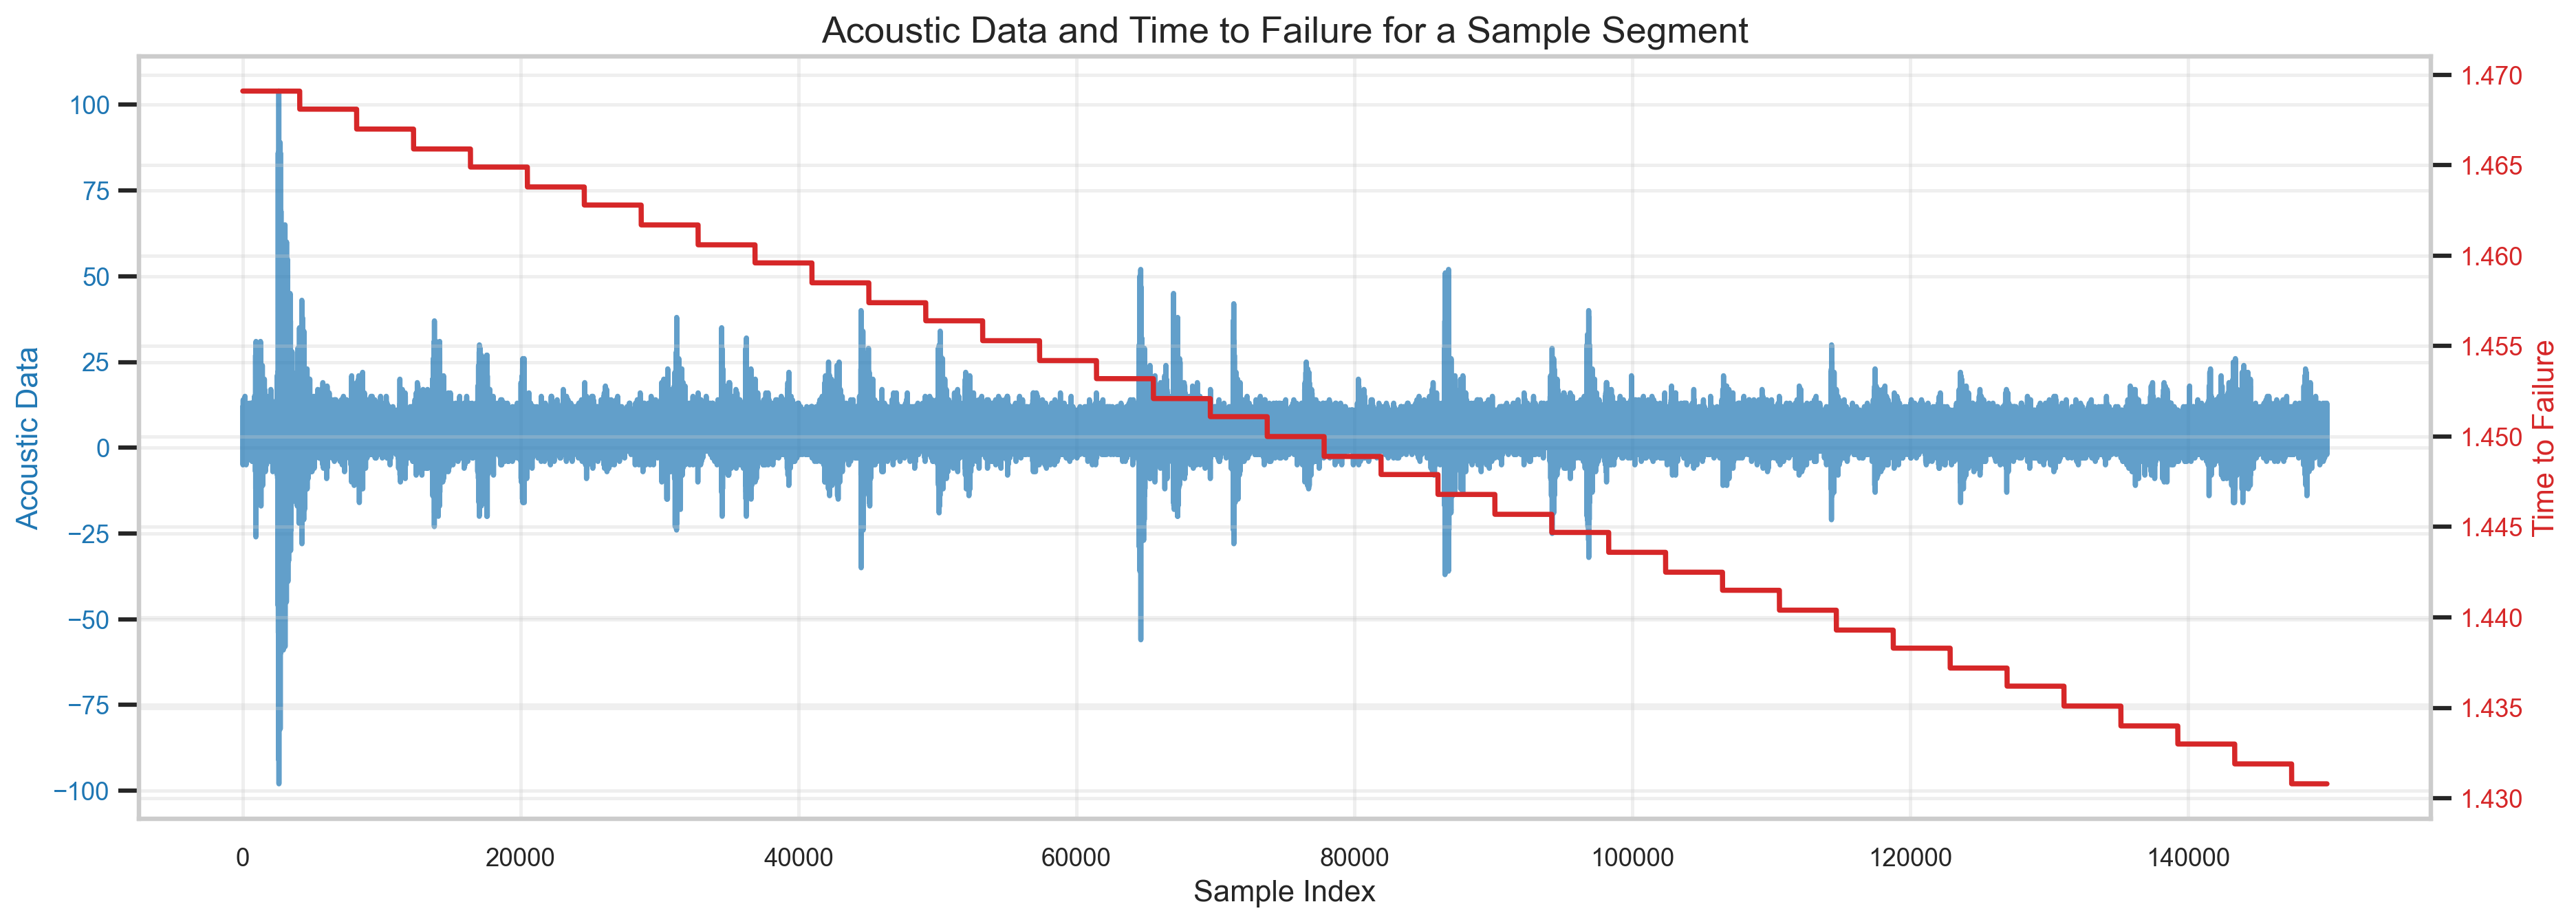

In [122]:
print("Visualizing a sample of the raw time-series data:")
data_loader.plot_eda_segment(train_df)


### Target Variable Distribution

This histogram shows the distribution of the final `time_to_failure` value for each 150,000-sample segment in the training data. The distribution is right-skewed, indicating that shorter times to failure are more common than very long ones. This is a critical characteristic for the model to learn.


Segmenting for Histogram:   0%|          | 0/400 [00:00<?, ?it/s]

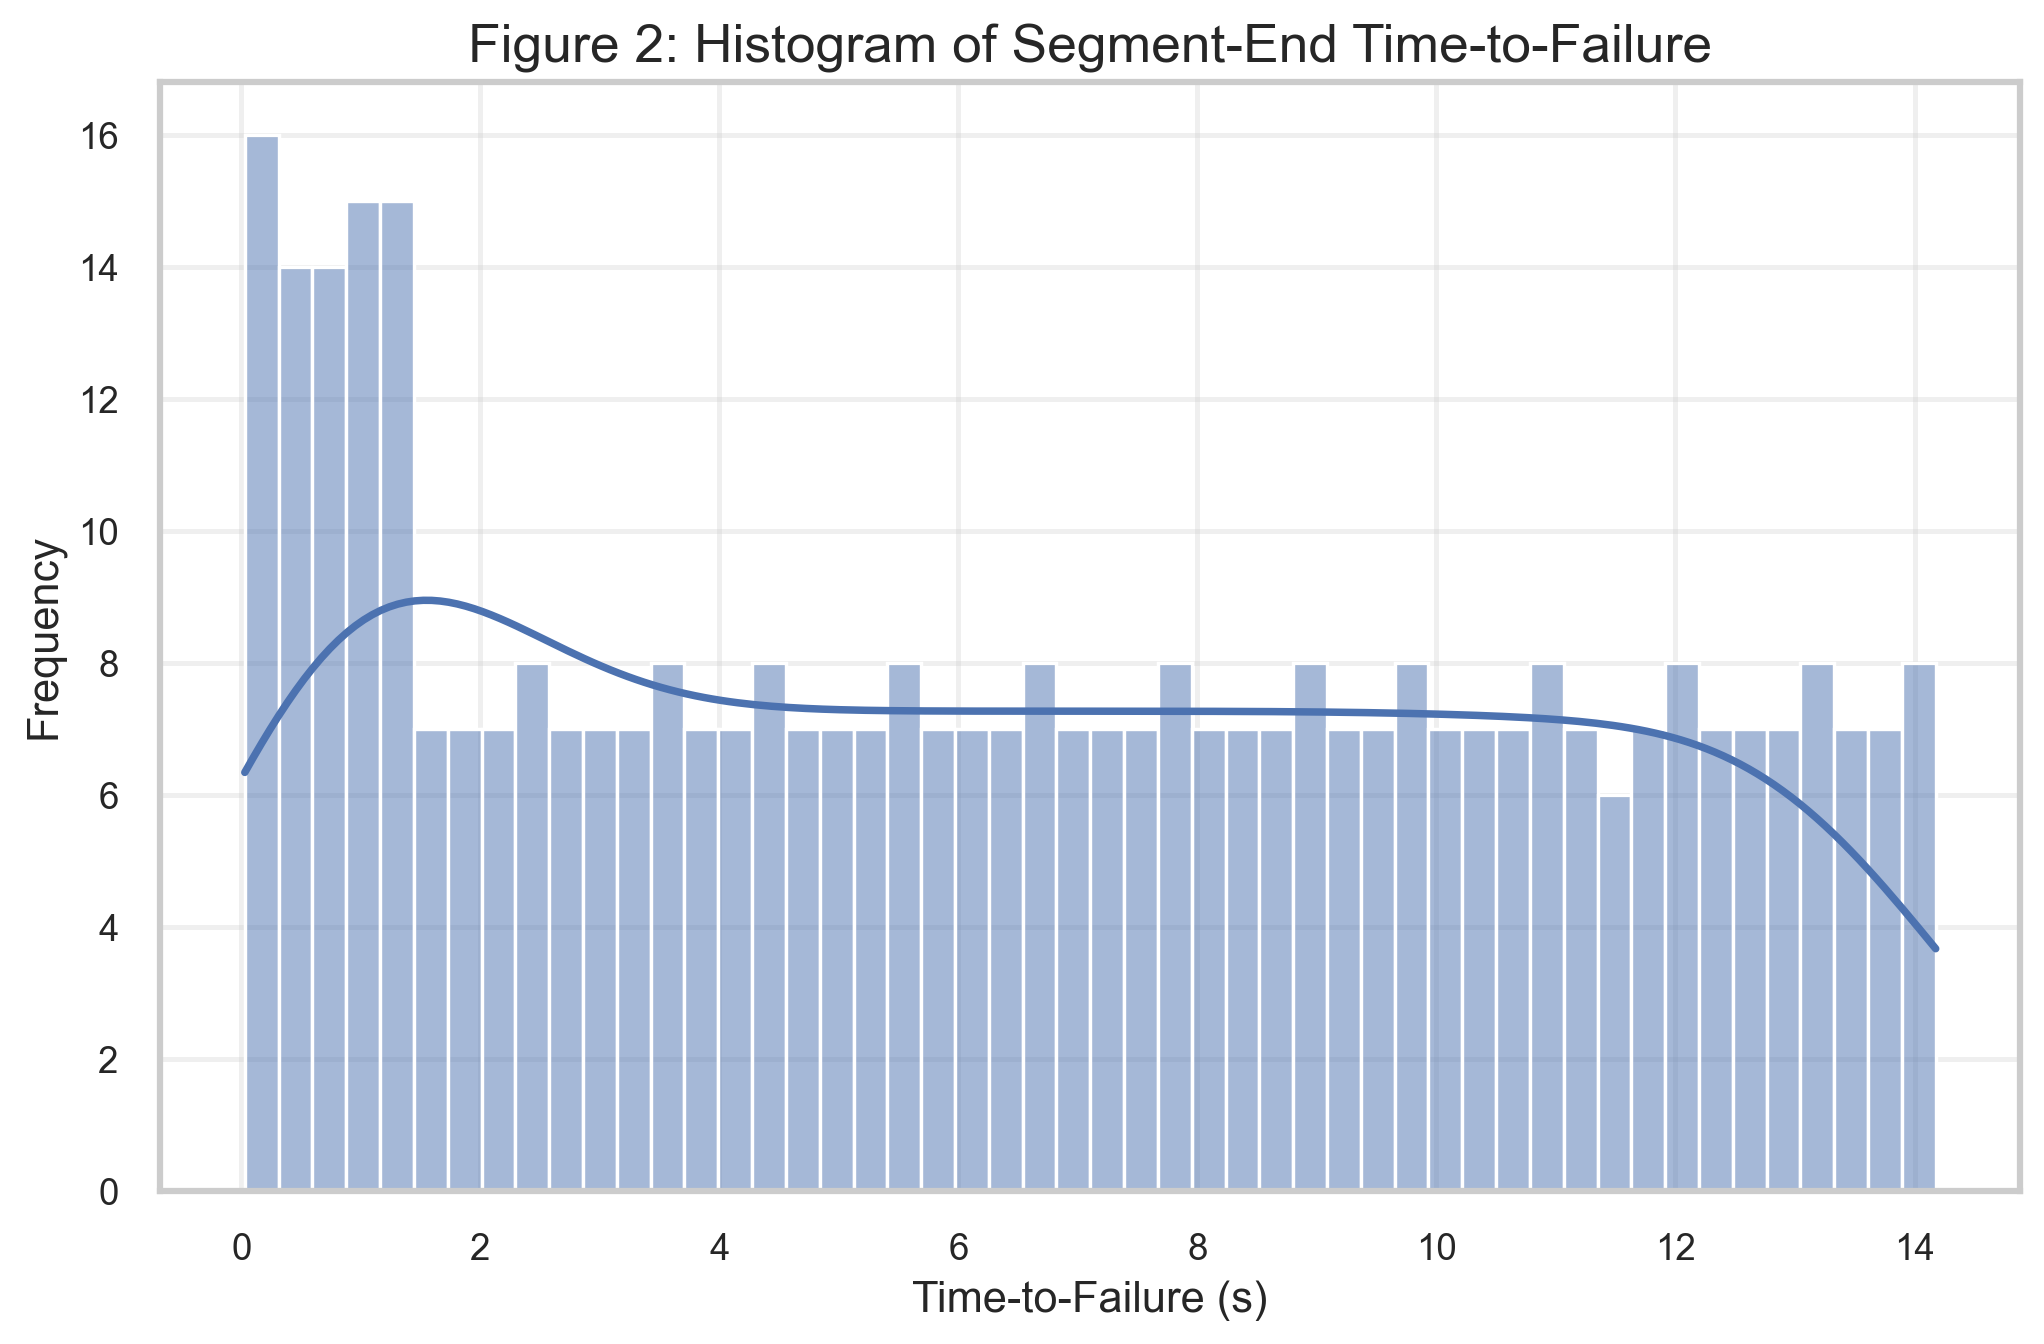

In [123]:
# Calculate the final time_to_failure for each segment
rows = 150_000
segments = len(train_df) // rows
y_train_hist = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

for idx in tqdm(range(segments), desc="Segmenting for Histogram"):
    seg = train_df.iloc[idx*rows : idx*rows + rows]
    y_train_hist.loc[idx, 'time_to_failure'] = seg['time_to_failure'].values[-1]

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(y_train_hist['time_to_failure'], bins=50, kde=True)
plt.xlabel('Time-to-Failure (s)')
plt.ylabel('Frequency')
plt.title('Figure 2: Histogram of Segment-End Time-to-Failure')
plt.show()


--- Analyzing Acoustic Data Distribution (Central 98% of Data) ---
Clipping data to the 1%-99% range: [-10.0, 19.0]


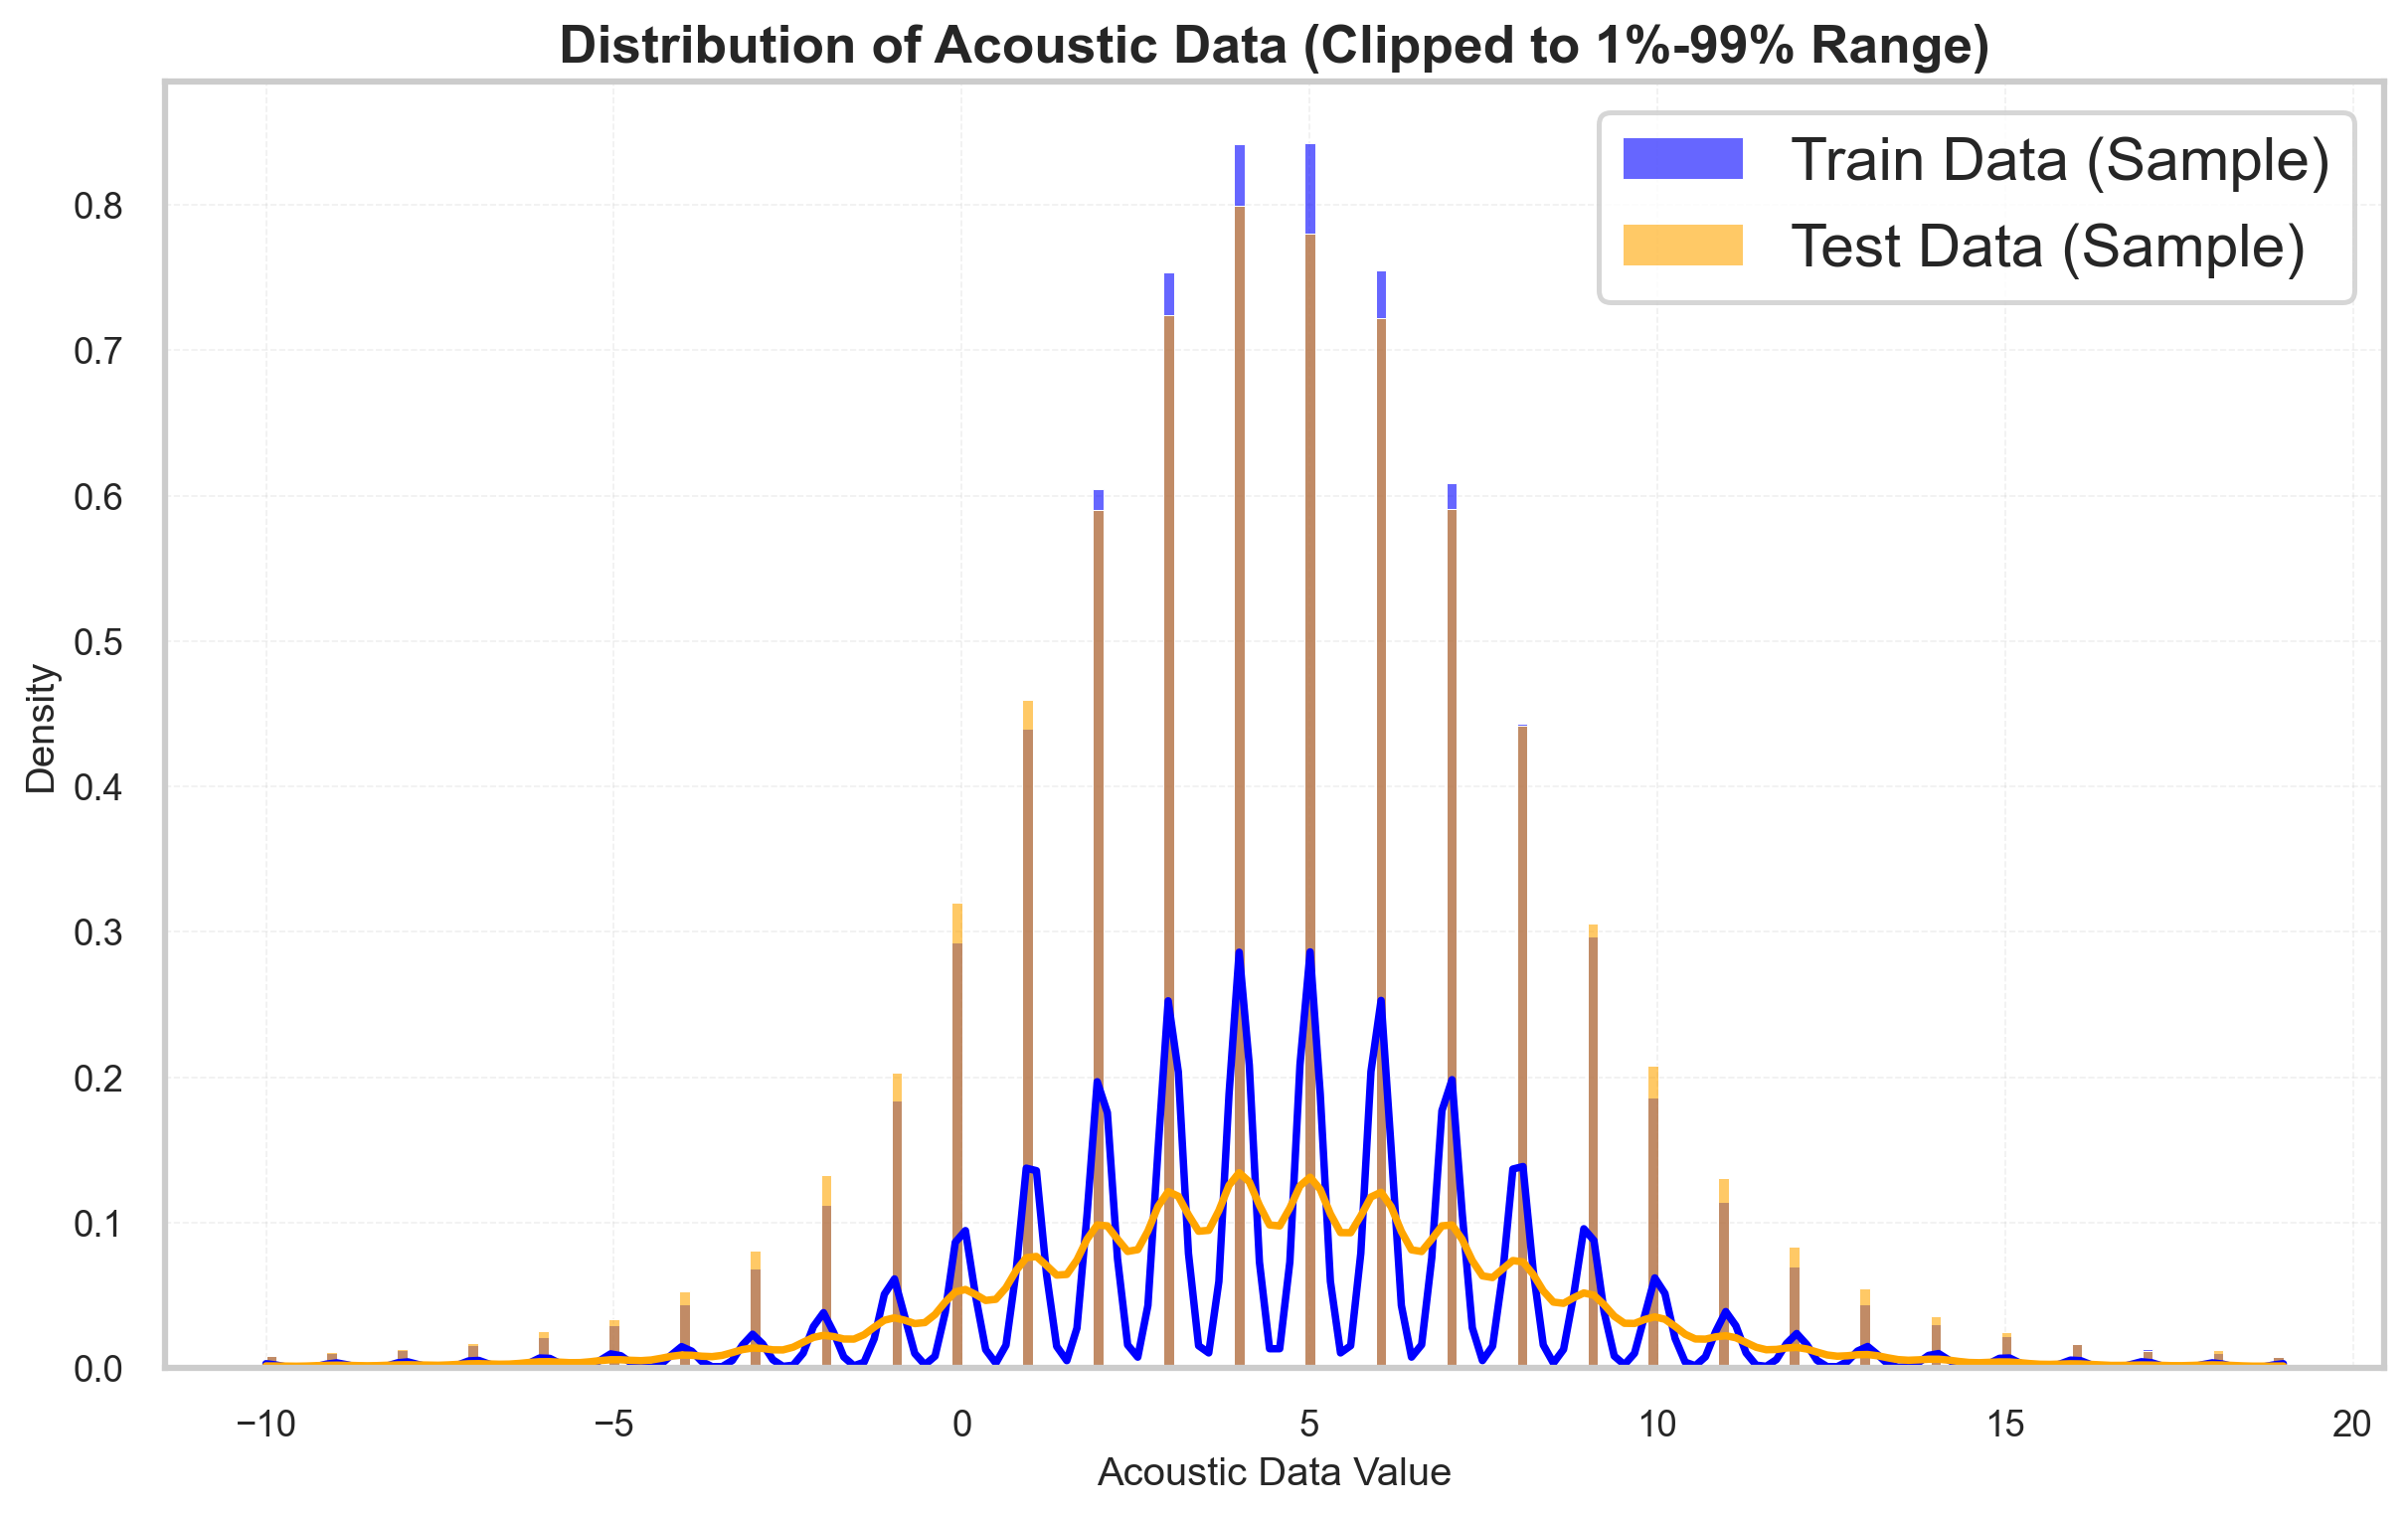


--- Kolmogorov-Smirnov Test Results ---
This test checks if the train and test samples are drawn from the same distribution.
KS-statistic: 0.0173
p-value: 1.521e-37
⚠ Low p-value (< 0.05) suggests a statistically significant difference between the distributions (distribution shift).


In [124]:
# --- Analyzing Acoustic Data Distribution (Train vs. Test) ---
# We plot the distribution of the acoustic_data to check for potential shifts between train and test sets.
# The raw signal has extreme outliers. Instead of hardcoding axis limits, a more robust
# method is to clip the data to its 1st and 99th percentiles to visualize its central distribution.

import os

print("--- Analyzing Acoustic Data Distribution (Central 98% of Data) ---")

# Use a large but manageable random sample for performance
sample_size = 5_000_000
train_sample_df = train_df.sample(n=min(sample_size, len(train_df)), random_state=42)

# Find the 1st and 99th percentiles from the training sample
low, high = train_sample_df['acoustic_data'].quantile([0.01, 0.99])
print(f"Clipping data to the 1%-99% range: [{low}, {high}]")

# Clip the training data
clipped_train_data = train_sample_df['acoustic_data'][(train_sample_df['acoustic_data'] >= low) & (train_sample_df['acoustic_data'] <= high)]

# Load and clip a sample test file
try:
    test_sample_path = os.path.join('test', 'seg_00030f.csv')
    test_sample_df = pd.read_csv(test_sample_path)
    clipped_test_data = test_sample_df['acoustic_data'][(test_sample_df['acoustic_data'] >= low) & (test_sample_df['acoustic_data'] <= high)]
    has_test_sample = True
except FileNotFoundError:
    print("Could not find sample test file. Plotting training data distribution only.")
    has_test_sample = False

# Create the plot
plt.figure(figsize=(12, 7))
sns.histplot(clipped_train_data, bins=200, kde=True, stat="density", label='Train Data (Sample)', color='blue', alpha=0.6)

if has_test_sample:
    sns.histplot(clipped_test_data, bins=200, kde=True, stat="density", label='Test Data (Sample)', color='orange', alpha=0.6)

plt.title('Distribution of Acoustic Data (Clipped to 1%-99% Range)', fontsize=16, fontweight='bold')
plt.xlabel('Acoustic Data Value', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Perform and report a Kolmogorov-Smirnov test to quantify the difference
if has_test_sample:
    ks_statistic, p_value = ks_2samp(clipped_train_data.to_numpy(), clipped_test_data.to_numpy())
    print(f"\n--- Kolmogorov-Smirnov Test Results ---")
    print(f"This test checks if the train and test samples are drawn from the same distribution.")
    print(f"KS-statistic: {ks_statistic:.4f}")
    print(f"p-value: {p_value:.4g}")
    if p_value < 0.05:
        print("⚠ Low p-value (< 0.05) suggests a statistically significant difference between the distributions (distribution shift).")
    else:
        print("✓ High p-value (>= 0.05) suggests we cannot reject the null hypothesis that the samples are from the same distribution.")


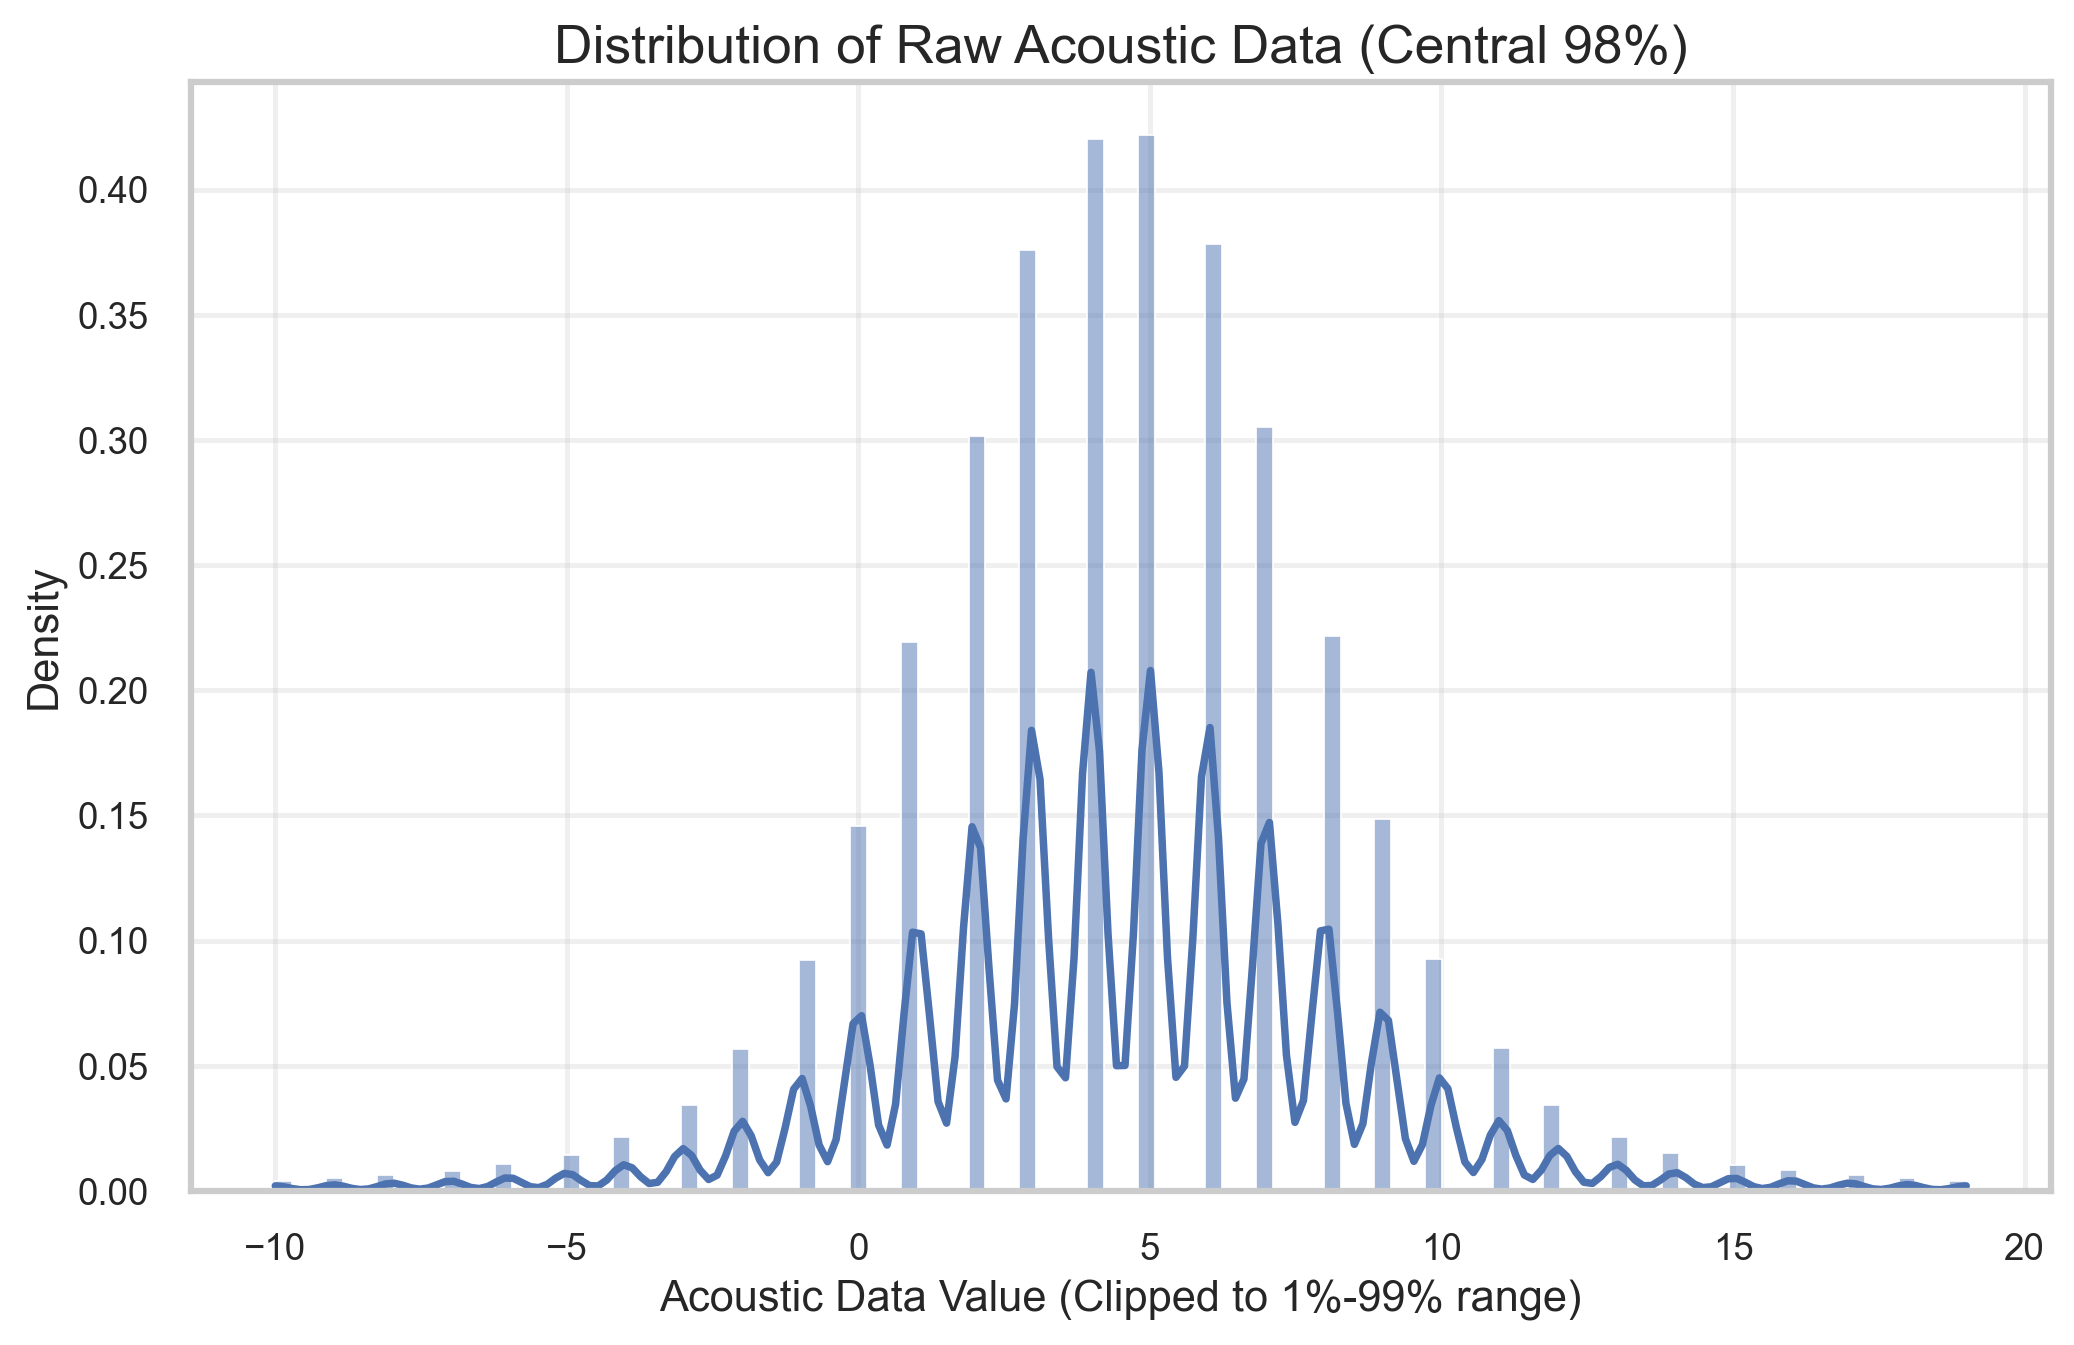

In [125]:
# Visualize the distribution of raw acoustic data, clipping outliers for clarity
sample_size = 1_000_000
sample_data = train_df['acoustic_data'].sample(n=min(sample_size, len(train_df)), random_state=42)
# Clip data to the 1st and 99th percentiles to handle extreme outliers
low, high = sample_data.quantile([0.01, 0.99])
clipped_data = sample_data[(sample_data >= low) & (sample_data <= high)]
plt.figure(figsize=(10, 6))
sns.histplot(clipped_data, bins=100, kde=True, stat='density')
plt.xlabel('Acoustic Data Value (Clipped to 1%-99% range)')
plt.ylabel('Density')
plt.title('Distribution of Raw Acoustic Data (Central 98%)')
plt.grid(True, alpha=0.3)
plt.show()


Loaded test sample: seg_00030f.csv


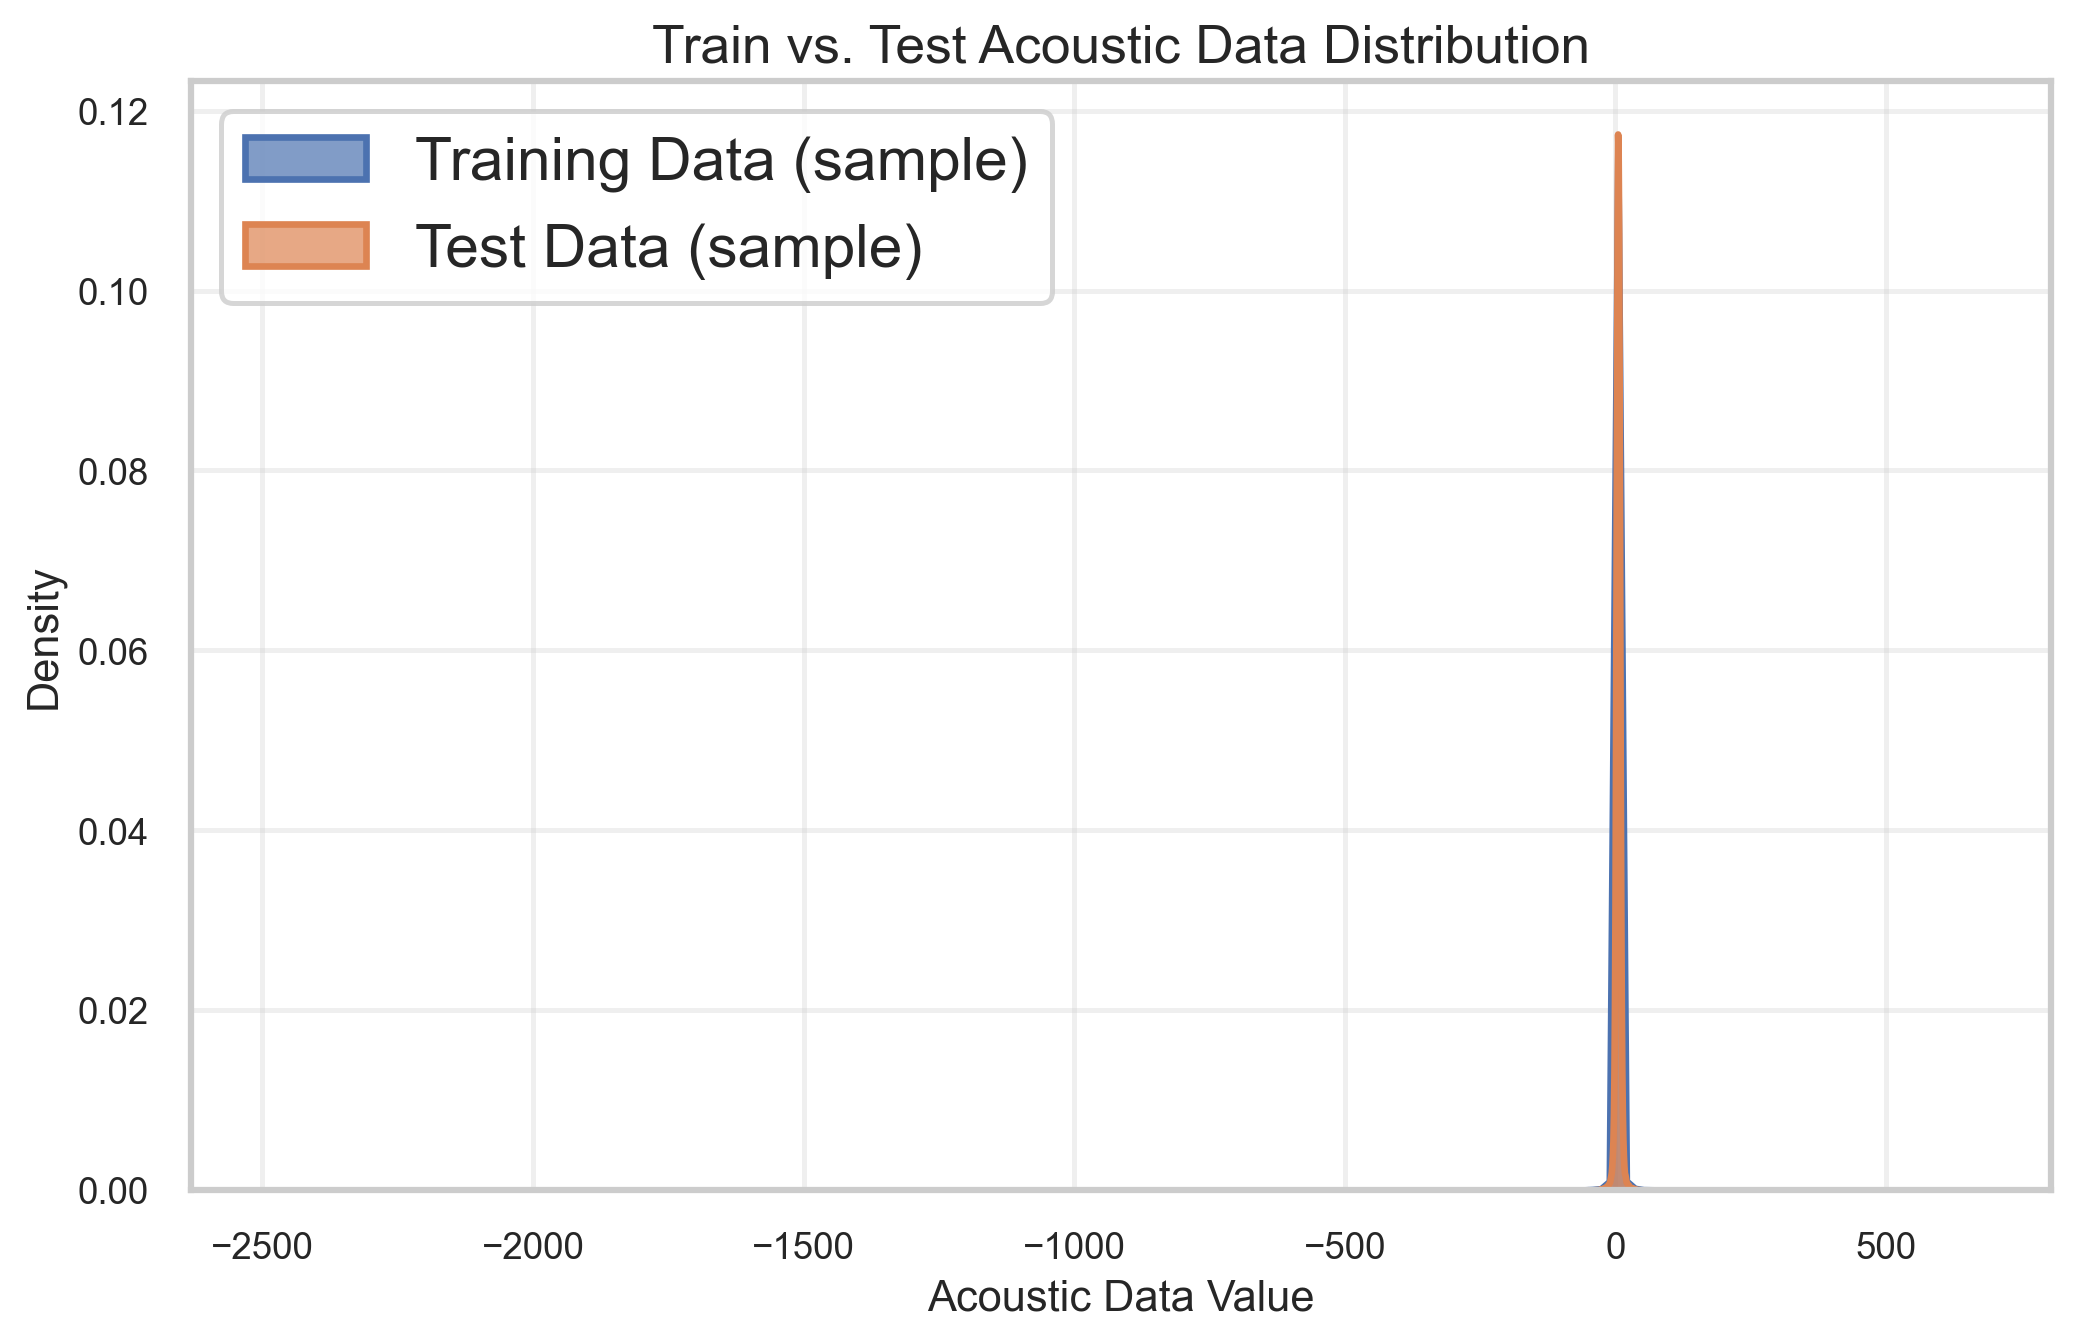


Kolmogorov-Smirnov Test Results:
KS-statistic: 0.0459
p-value: 0.0000
⚠ Low p-value suggests a potential distribution shift.


In [126]:
# Compare train vs test data distribution
import os
import glob
from scipy.stats import ks_2samp
try:
    test_files = sorted(glob.glob(os.path.join('test', '*.csv')))
    if test_files:
        test_sample_df = pd.read_csv(test_files[0], dtype={'acoustic_data': np.int16})
        print(f"Loaded test sample: {os.path.basename(test_files[0])}")
        # Use equal-sized random samples for a fair visual comparison
        sample_size = 150_000
        train_sample = train_df['acoustic_data'].sample(n=sample_size, random_state=42)
        test_sample = test_sample_df['acoustic_data'].sample(n=sample_size, random_state=42)
        # Perform Kolmogorov-Smirnov test on the full segments
        ks_statistic, p_value = ks_2samp(train_df['acoustic_data'].iloc[:sample_size], test_sample_df['acoustic_data'])
        plt.figure(figsize=(10, 6))
        sns.kdeplot(train_sample, label='Training Data (sample)', alpha=0.7, linewidth=2, fill=True)
        sns.kdeplot(test_sample, label='Test Data (sample)', alpha=0.7, linewidth=2, fill=True)
        plt.xlabel('Acoustic Data Value')
        plt.ylabel('Density')
        plt.title('Train vs. Test Acoustic Data Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        print(f"\nKolmogorov-Smirnov Test Results:")
        print(f"KS-statistic: {ks_statistic:.4f}")
        print(f"p-value: {p_value:.4f}")
        if p_value > 0.05:
            print("✓ High p-value suggests the train and test samples are from the same distribution.")
        else:
            print("⚠ Low p-value suggests a potential distribution shift.")
    else:
        print("No test files found in 'test' directory.")
except Exception as e:
    print(f"Error comparing distributions: {e}")


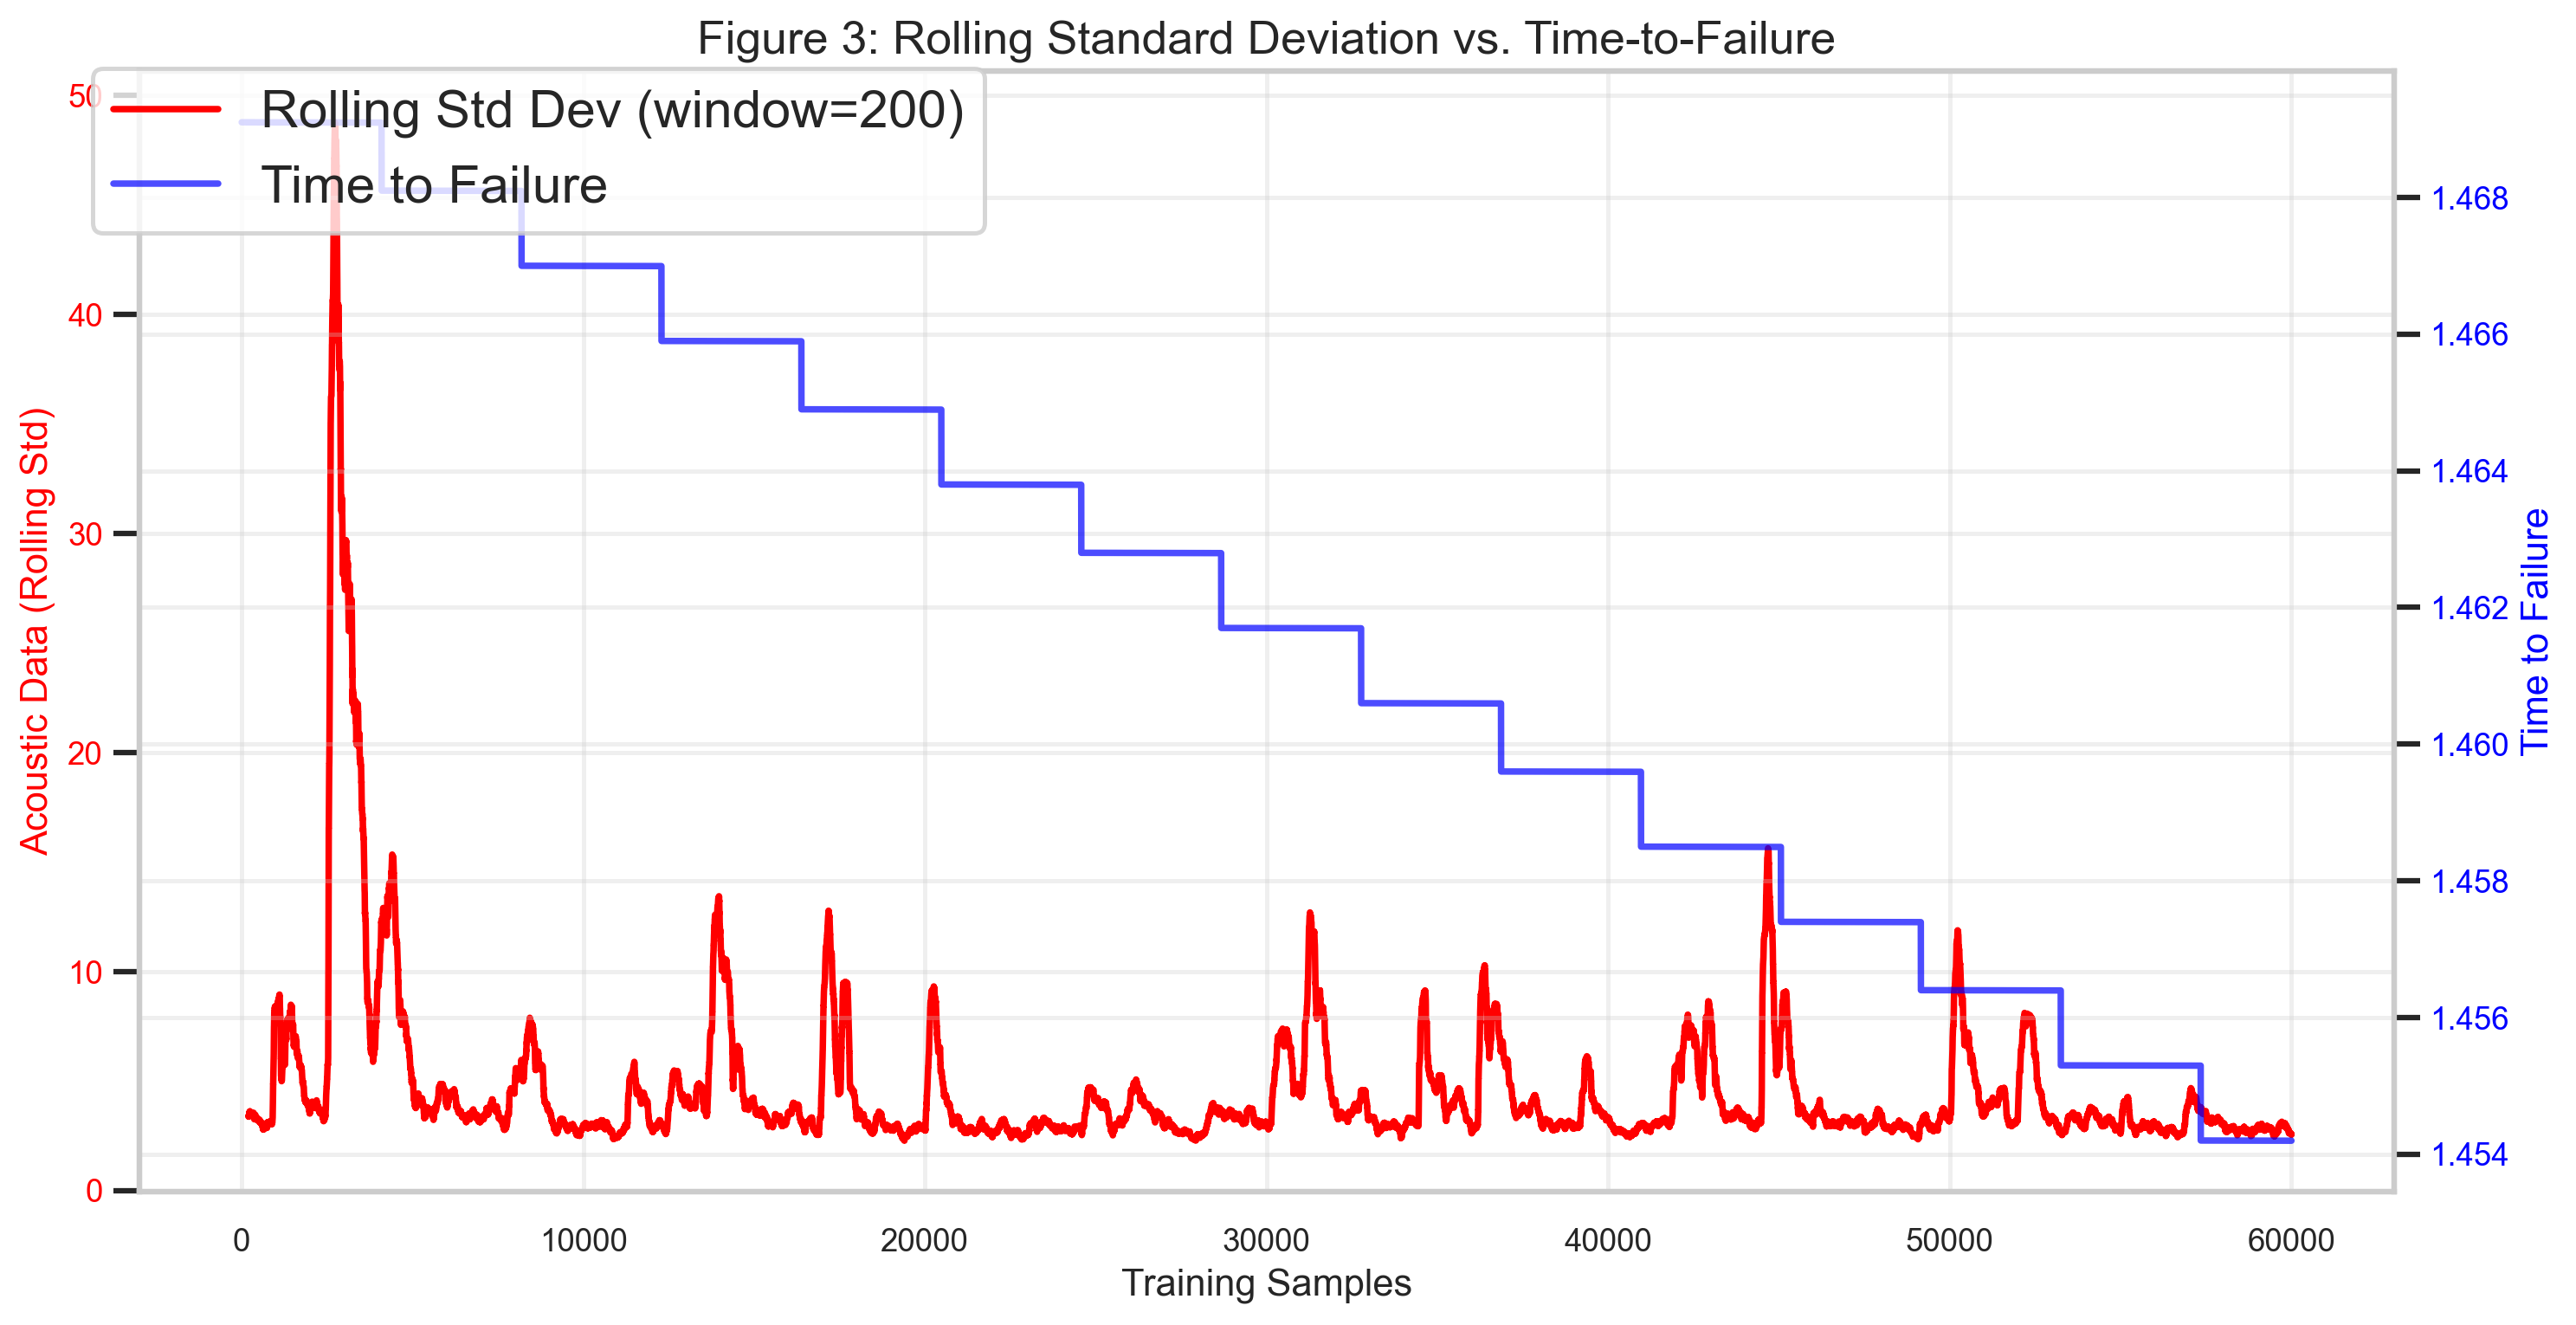

In [127]:
# Use a smaller slice of the data for performance
train_sample = train_df.iloc[:60000].copy()

# Calculate rolling standard deviation
window = 200
roll_std = train_sample['acoustic_data'].rolling(window=window).std().dropna()

fig, ax1 = plt.subplots(figsize=(14, 7))
plt.title('Figure 3: Rolling Standard Deviation vs. Time-to-Failure')

# Plot the rolling feature
ax1.plot(roll_std.index, roll_std.values, color='red', label='Rolling Std Dev (window=200)')
ax1.set_xlabel('Training Samples')
ax1.set_ylabel('Acoustic Data (Rolling Std)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Plot the time to failure on a second y-axis
ax2 = ax1.twinx()
ax2.plot(train_sample.index, train_sample['time_to_failure'], color='blue', alpha=0.7, label='Time to Failure')
ax2.set_ylabel('Time to Failure', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()


## 3. Feature Analysis

Before diving into model results, let's understand which engineered features and statistics are most predictive using a simple linear model and correlation-based analysis. This tells us what signal characteristics are most valuable.


Loading data for feature importance analysis (using a 30M row subset for efficiency)...
Loaded 30,000,000 rows from data\train.csv
Preparing features...
Starting data preparation: Engineering features into sequences...


  0%|          | 0/200 [00:00<?, ?it/s]


Final data shape for temporal models: Train=(160, 10, 15), Val=(40, 10, 15)
Extracting data from loader...
Training Ridge regression model...
Computing permutation importance...


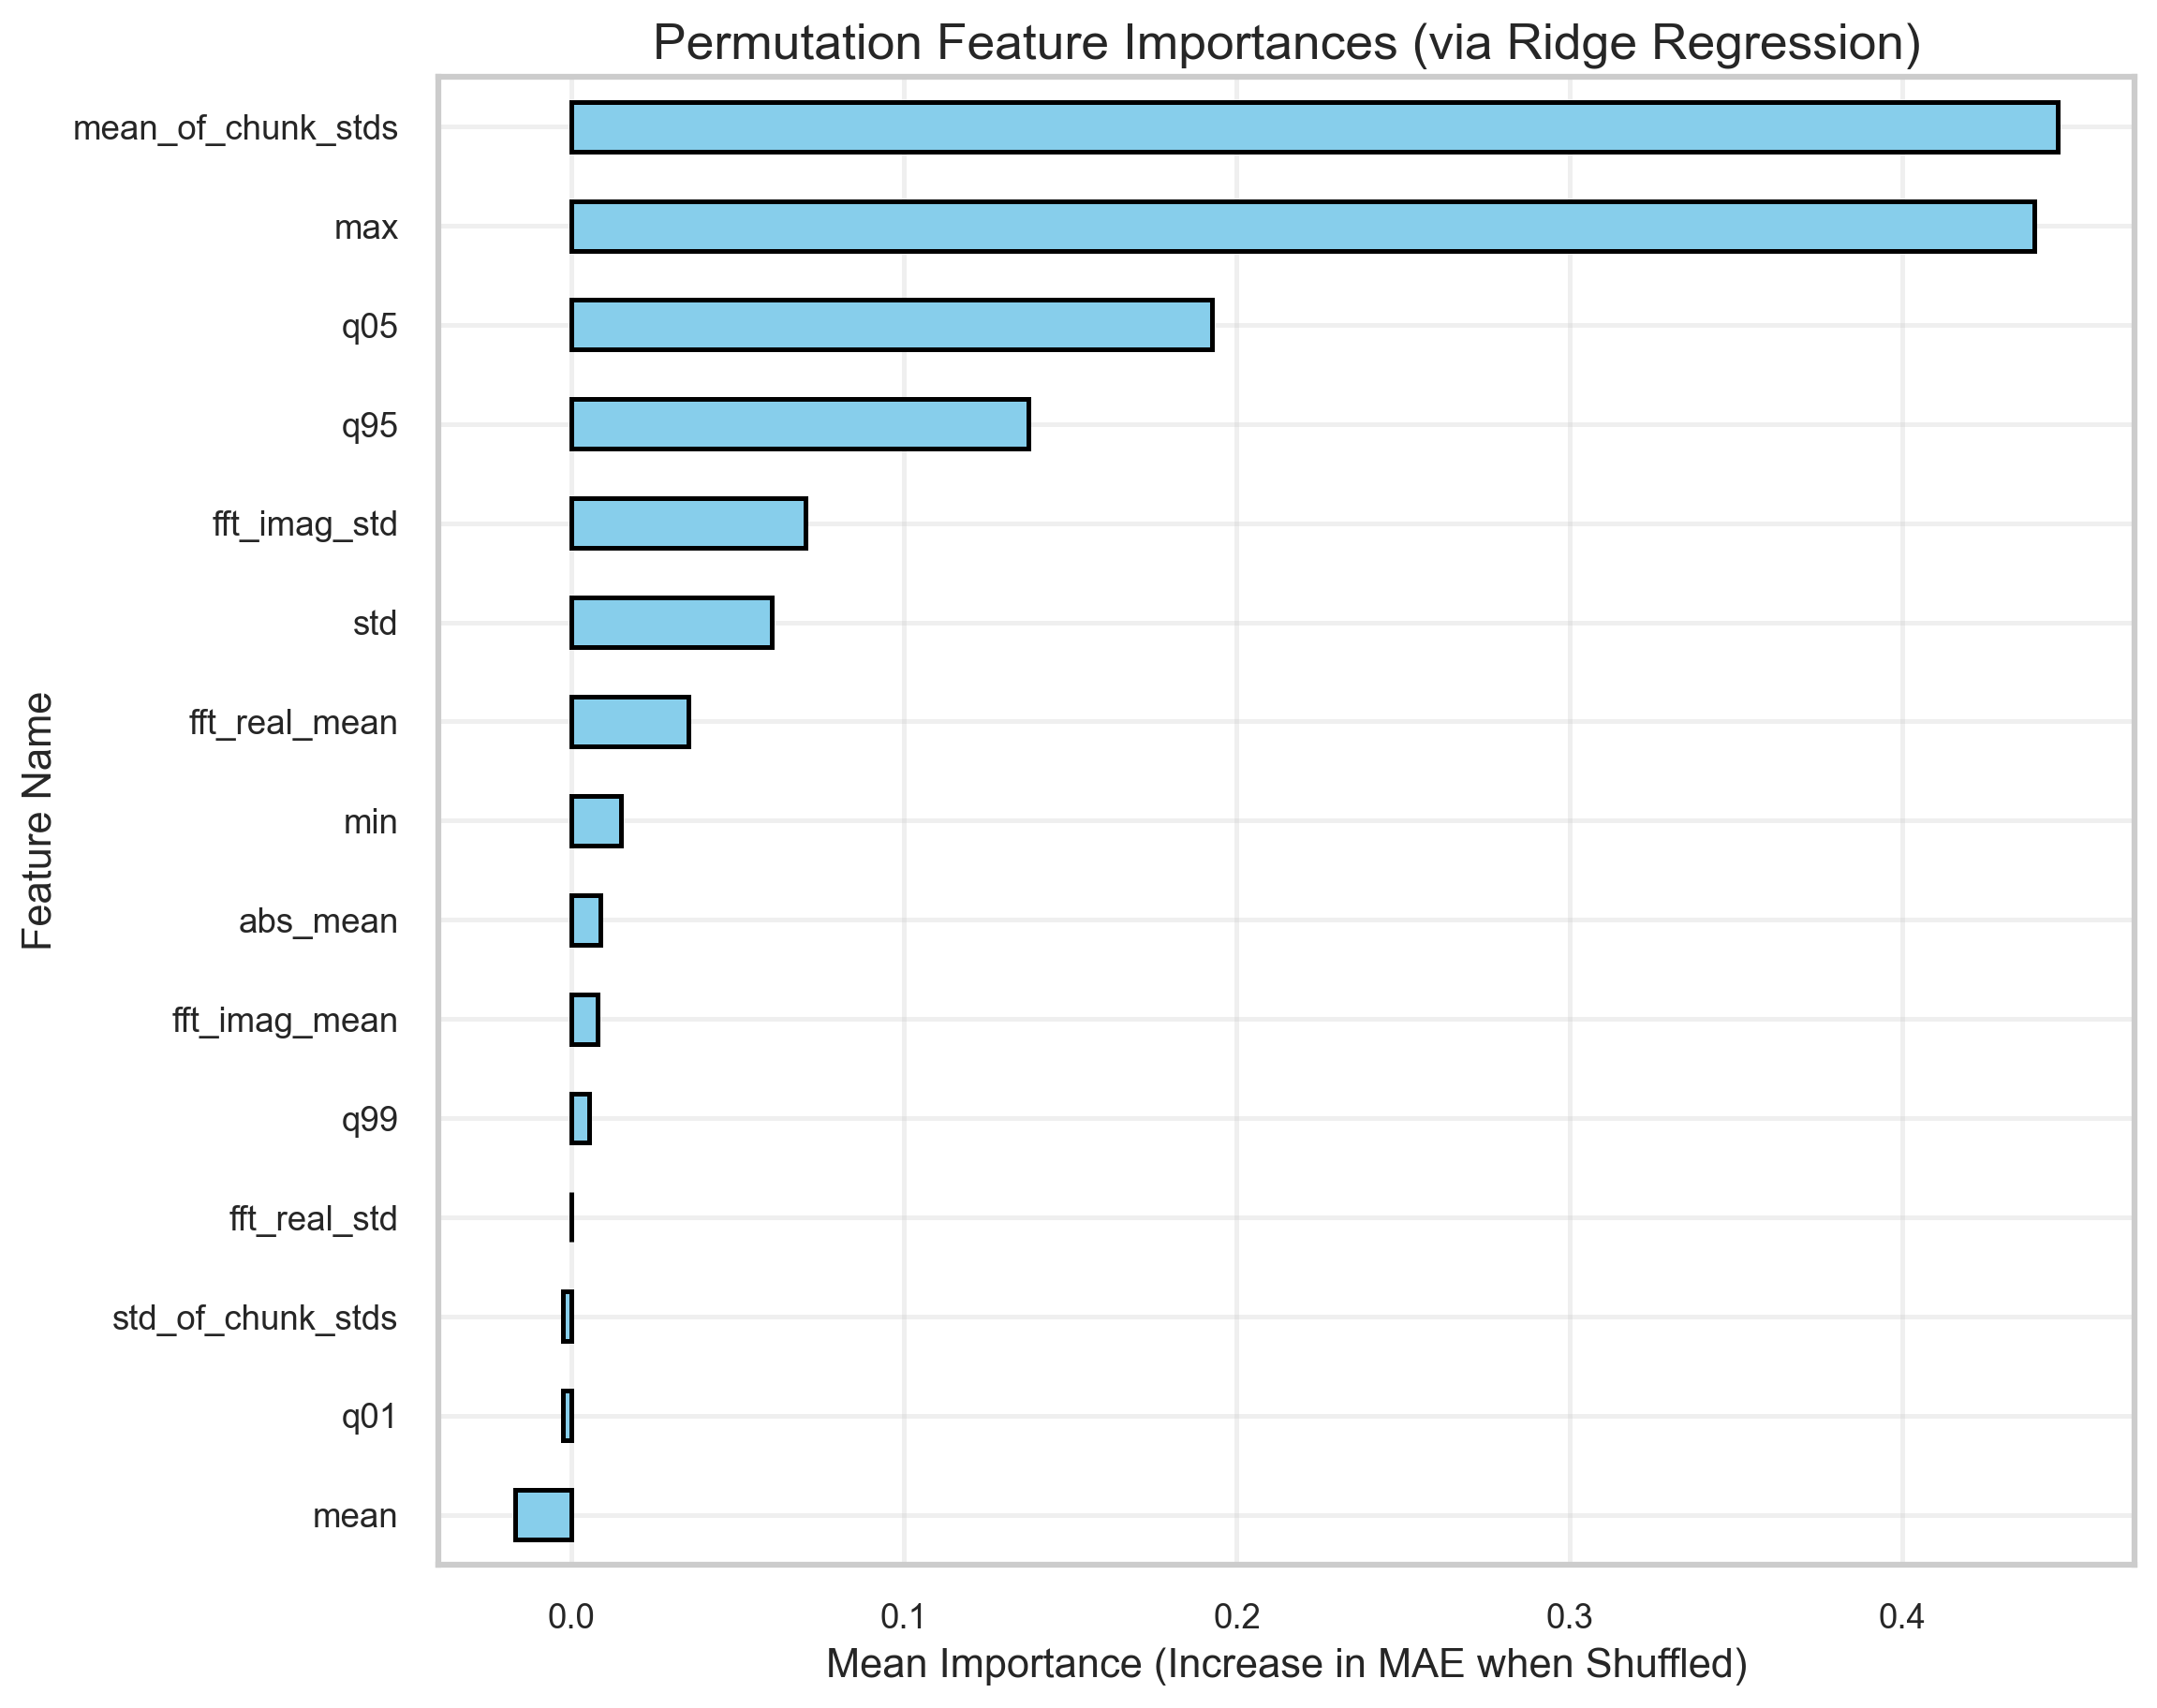


Top 10 Most Important Features:
mean_of_chunk_stds    0.446619
max                   0.439656
q05                   0.192615
q95                   0.137377
fft_imag_std          0.070456
std                   0.060293
fft_real_mean         0.035421
min                   0.014908
abs_mean              0.008881
fft_imag_mean         0.008000
dtype: float64


In [128]:
from sklearn.linear_model import Ridge
from sklearn.inspection import permutation_importance
import data_pipeline
import config
try:
    print("Loading data for feature importance analysis (using a 30M row subset for efficiency)...")
    df_sample = data_loader.load_data(config.TRAIN_DATA_PATH, nrows=30_000_000)
    print("Preparing features...")
    train_loader_fi, _, num_features, feature_names, _ = data_pipeline.prepare_data(df_sample, test_size=0.2)
    print("Extracting data from loader...")
    X_train_list, y_train_list = [], []
    for Xb, yb in train_loader_fi:
        X_train_list.append(Xb.numpy())
        y_train_list.append(yb.numpy())
    X_train_s = np.concatenate(X_train_list, axis=0)
    y_train_s = np.concatenate(y_train_list, axis=0)
    X_train_last_step = X_train_s[:, -1, :]
    y_train_flat = y_train_s.flatten()
    print("Training Ridge regression model...")
    linear_model = Ridge(alpha=1.0).fit(X_train_last_step, y_train_flat)
    print("Computing permutation importance...")
    result = permutation_importance(
        linear_model, X_train_last_step, y_train_flat, 
        n_repeats=5, random_state=42, n_jobs=-1, scoring='neg_mean_absolute_error'
    )
    # Sort ascending=True for horizontal bar chart (highest bar on top)
    importances = pd.Series(result.importances_mean, index=feature_names).sort_values(ascending=True)
    plt.figure(figsize=(10, 8))
    importances.plot(kind='barh', color='skyblue', edgecolor='black')
    plt.title('Permutation Feature Importances (via Ridge Regression)')
    plt.xlabel('Mean Importance (Increase in MAE when Shuffled)')
    plt.ylabel('Feature Name')
    plt.tight_layout()
    plt.show()
    print("\nTop 10 Most Important Features:")
    print(importances.sort_values(ascending=False).head(10))
except Exception as e:
    print(f"Feature importance analysis skipped: {e}")


#### Interpretation of Feature Importance

The permutation importance plot reveals several key insights:

- **Dominance of Quantiles:** Features like `q99`, `q95`, `q01`, and `q05` are among the most important. This strongly suggests that extreme values and sharp spikes in the acoustic signal are highly predictive of an impending failure event.

- **Value of Rolling Statistics:** The `std_of_chunk_stds` and `mean_of_chunk_stds` are also highly ranked. This confirms our EDA hypothesis that changes in volatility over time (i.e., the standard deviation of standard deviations) are a critical indicator.

- **Low Impact of FFT Means:** The mean of the FFT components (`fft_real_mean`, `fft_imag_mean`) have very low importance, suggesting that the average frequency profile is less important than the signal's volatility and extreme values.


## 4. Model & Optimizer Performance Analysis

This section summarizes model-optimizer performance across all experiments and visualizes the best architecture-wise performance and optimizer dynamics for the top model.



--- Summary of Best Performance per Optimizer-Model Combination ---


Model                Optimizer  Best_Val_MAE Best_Val_RMSE  \
0  Hybrid w/ Attention  SGD_Momentum_OneCycleLR      2.276890           N/A   
1      Hybrid CNN-LSTM  SGD_Momentum_OneCycleLR      2.295646           N/A   
2  Hybrid w/ Attention            Adam_StaticLR      2.321799           N/A   
3      Hybrid CNN-LSTM         AdamW_OneCycleLR      2.324665           N/A   
4      Hybrid CNN-LSTM            Adam_CyclicLR      2.333374           N/A   
5  Hybrid w/ Attention          Adam_OneCycleLR      2.344521           N/A   
6      Hybrid CNN-LSTM            Adam_StaticLR      2.349036           N/A   
7  Hybrid w/ Attention            Adam_CyclicLR      2.359125           N/A   
8      Hybrid CNN-LSTM          Adam_OneCycleLR      2.363119           N/A   
9                 LSTM          Adam_OneCycleLR      2.366263           N/A   

  Best_Val_R2  Best_Epoch  
0         N/A          29  
1         N/A          21  
2         N/A          10  
3         N/A          21  
4         N/A          17  
5         N/A          16  
6         N/A          22  
7         N/A          12  
8         N/A          33  
9         N/A          19

C:\Users\Hamda\AppData\Local\Temp\ipykernel_20580\713517993.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Optimizer', y='Best_Val_MAE', data=performers_df, palette='muted')


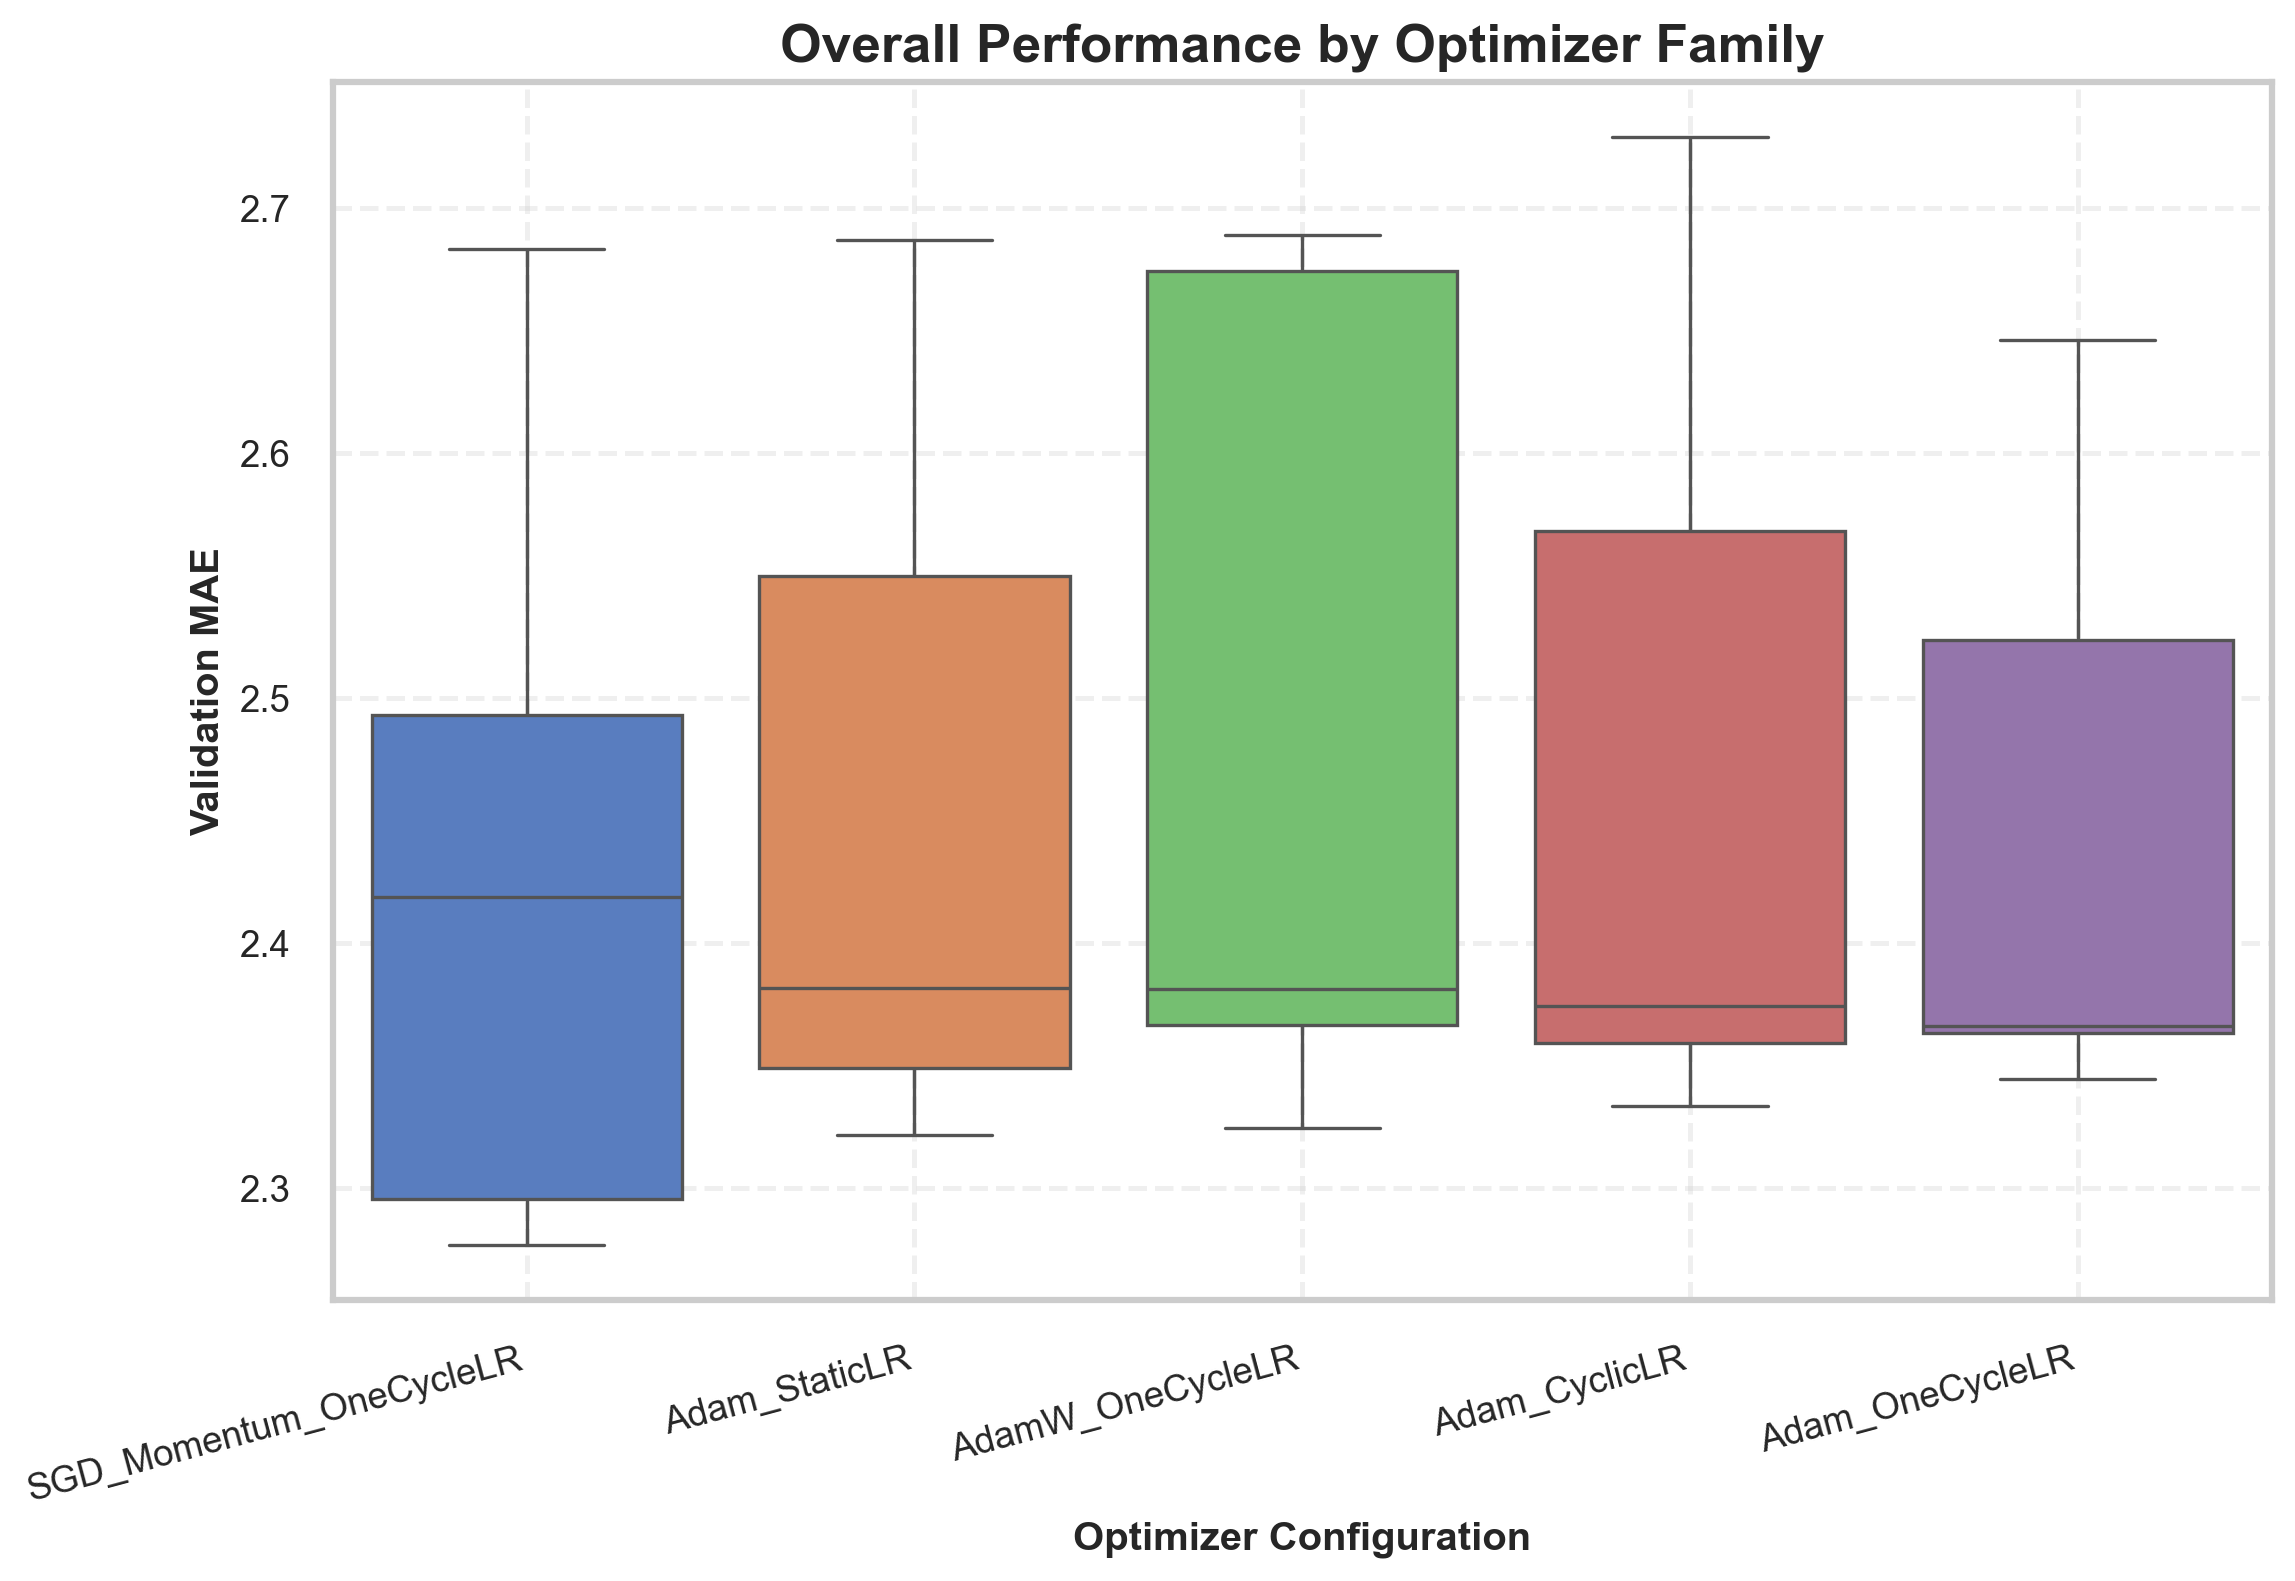


--- Best Performing Configuration for Each Model Architecture ---


Model                Optimizer  Best_Val_MAE  \
0      Hybrid w/ Attention  SGD_Momentum_OneCycleLR      2.276890   
1          Hybrid CNN-LSTM  SGD_Momentum_OneCycleLR      2.295646   
9                     LSTM          Adam_OneCycleLR      2.366263   
15                  1D CNN  SGD_Momentum_OneCycleLR      2.493177   
19  MLPER-Inspired (Image)          Adam_OneCycleLR      2.645849   

   Best_Val_RMSE Best_Val_R2  Best_Epoch  
0            N/A         N/A          29  
1            N/A         N/A          21  
9            N/A         N/A          19  
15           N/A         N/A          18  
19           N/A         N/A          28

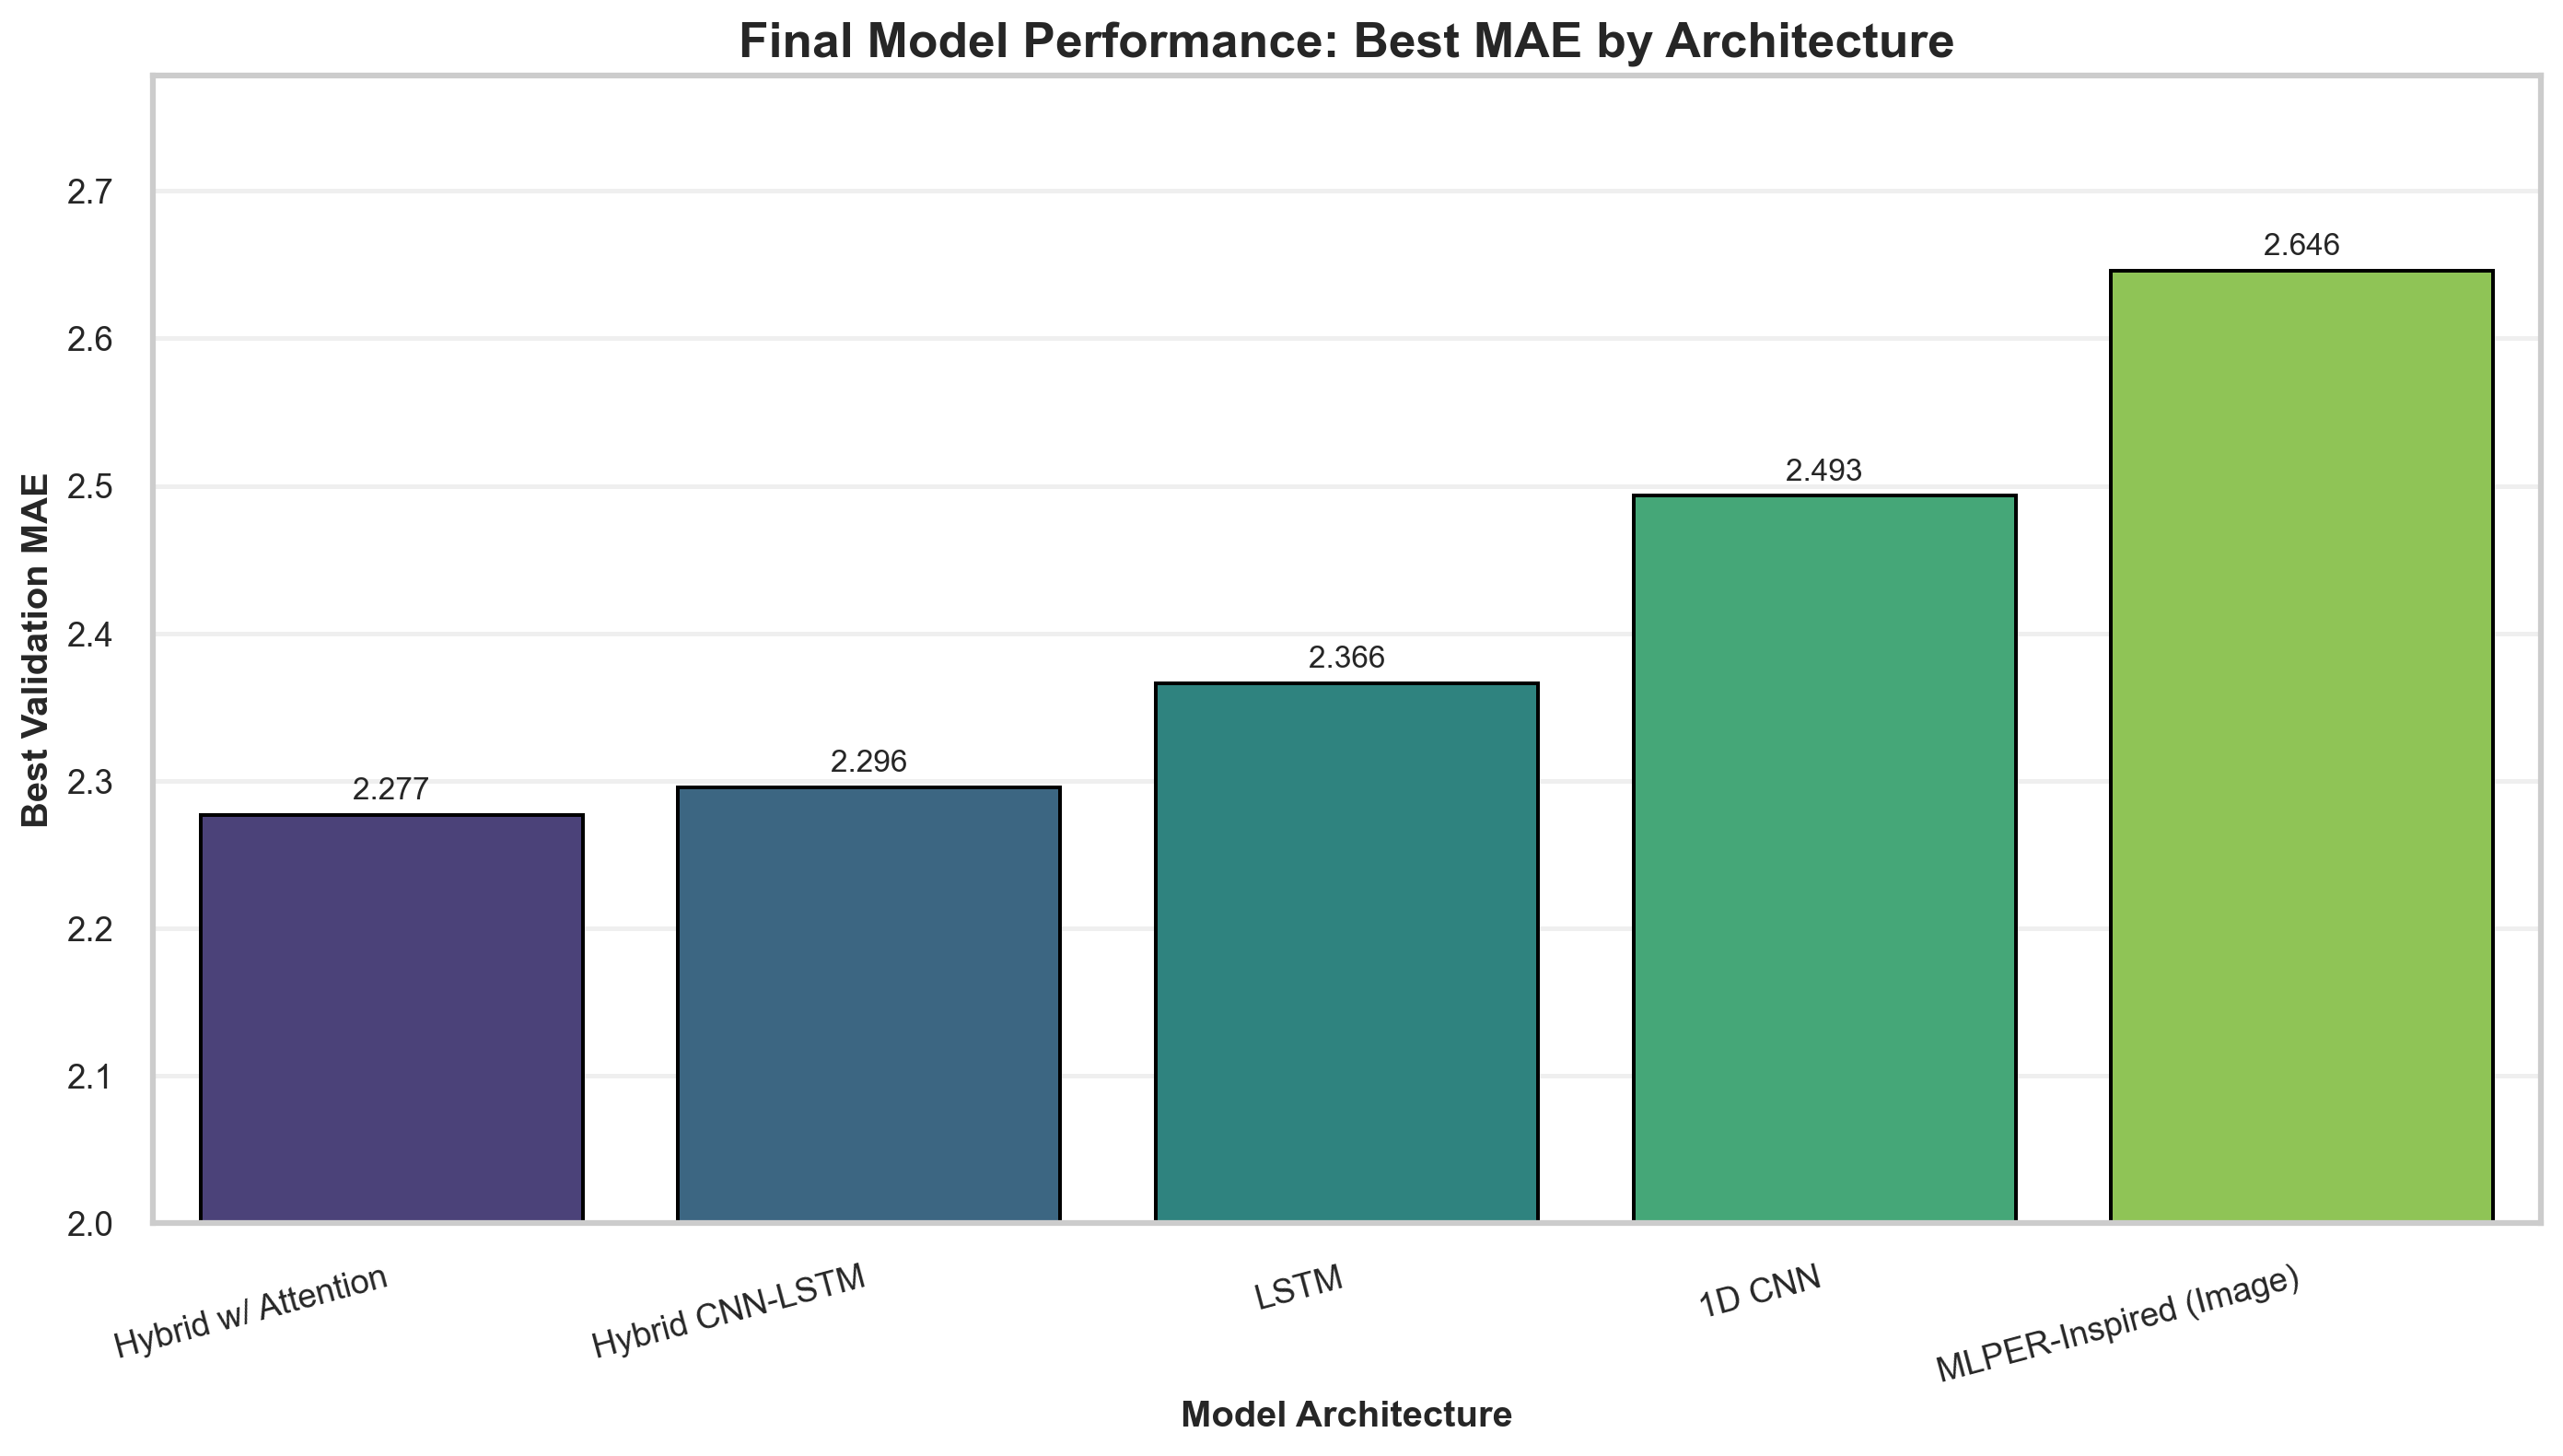

In [129]:
import json
import pandas as pd

try:
    with open('training_histories.json', 'r') as f:
        histories = json.load(f)
    
    results_list = []
    for model_name, optimizers in histories.items():
        for optimizer_name, data in optimizers.items():
            results_list.append({
                'Model': model_name,
                'Optimizer': optimizer_name,
                'Best_Val_MAE': data.get('best_val_mae'),
                'Best_Val_RMSE': data.get('best_val_rmse', 'N/A'), # Add RMSE
                'Best_Val_R2': data.get('best_val_r2', 'N/A'),     # Add R-squared
                'Best_Epoch': data.get('best_epoch')
            })
    
    performers_df = pd.DataFrame(results_list)
    performers_df = performers_df.sort_values('Best_Val_MAE').reset_index(drop=True)
    
    print("--- Summary of Best Performance per Optimizer-Model Combination ---")
    display(performers_df.head(10)) # Display top 10

    # --- New Visualization: Overall Optimizer Performance ---
    plt.figure(figsize=(10, 7))
    sns.boxplot(x='Optimizer', y='Best_Val_MAE', data=performers_df, palette='muted')
    plt.xlabel('Optimizer Configuration', fontsize=12, fontweight='bold')
    plt.ylabel('Validation MAE', fontsize=12, fontweight='bold')
    plt.title('Overall Performance by Optimizer Family', fontsize=16, fontweight='bold')
    plt.xticks(rotation=15, ha='right')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()
    
    # --- Improved Visualization: Best Performance per Model Architecture ---
    best_per_model_df = performers_df.loc[performers_df.groupby('Model')['Best_Val_MAE'].idxmin()].sort_values('Best_Val_MAE')
    
    print("\n--- Best Performing Configuration for Each Model Architecture ---")
    display(best_per_model_df)
    
    plt.figure(figsize=(12, 7))
    bar_plot = sns.barplot(
        x='Model', 
        y='Best_Val_MAE', 
        data=best_per_model_df, 
        hue='Model',
        palette='viridis',
        edgecolor='black',
        linewidth=1.2,
        dodge=False,
        legend=False
    )
    
    for container in bar_plot.containers:
        bar_plot.bar_label(container, fmt='%.3f', padding=3, fontsize=10)

    plt.xlabel('Model Architecture', fontsize=12, fontweight='bold')
    plt.ylabel('Best Validation MAE', fontsize=12, fontweight='bold')
    plt.title('Final Model Performance: Best MAE by Architecture', fontsize=16, fontweight='bold')
    plt.xticks(rotation=15, ha='right')
    plt.ylim(bottom=2.0, top=best_per_model_df['Best_Val_MAE'].max() * 1.05)
    plt.tight_layout()
    plt.show()
    
except FileNotFoundError:
    print("training_histories.json not found. Please run 'python experiment.py' first.")
except Exception as e:
    print(f"An error occurred: {e}")


In [130]:
# Display Top 25 Model-Optimizer Combinations
try:
    if 'performers_df' not in globals() or performers_df.empty:
        raise NameError("Run the previous cell first to load 'performers_df'.")
    # Sort by Best_Val_MAE and get top 25
    top_25_df = performers_df.sort_values('Best_Val_MAE').head(25).copy()
    top_25_df = top_25_df.reset_index(drop=True)
    top_25_df.index = top_25_df.index + 1  # Start ranking from 1
    top_25_df.index.name = 'Rank'
    # Format the dataframe for better display
    display_df = top_25_df[['Model', 'Optimizer', 'Best_Val_MAE', 'Best_Epoch']].copy()
    display_df.columns = ['Model', 'Optimizer', 'Validation MAE', 'Best Epoch']
    display_df['Validation MAE'] = display_df['Validation MAE'].round(4)
    print("=" * 80)
    print("TOP 25 MODEL-OPTIMIZER COMBINATIONS")
    print("=" * 80)
    display(display_df)
    print(f"\nTotal combinations evaluated: {len(performers_df)}")
    print(f"Best Validation MAE: {performers_df['Best_Val_MAE'].min():.4f}")
    print(f"Worst Validation MAE: {performers_df['Best_Val_MAE'].max():.4f}")
except NameError as e:
    print(f"Error: {e}. Please run the previous cell first.")
except Exception as e:
    print(f"An error occurred: {e}")


TOP 25 MODEL-OPTIMIZER COMBINATIONS


Model                Optimizer  Validation MAE  \
Rank                                                                    
1        Hybrid w/ Attention  SGD_Momentum_OneCycleLR          2.2769   
2            Hybrid CNN-LSTM  SGD_Momentum_OneCycleLR          2.2956   
3        Hybrid w/ Attention            Adam_StaticLR          2.3218   
4            Hybrid CNN-LSTM         AdamW_OneCycleLR          2.3247   
5            Hybrid CNN-LSTM            Adam_CyclicLR          2.3334   
6        Hybrid w/ Attention          Adam_OneCycleLR          2.3445   
7            Hybrid CNN-LSTM            Adam_StaticLR          2.3490   
8        Hybrid w/ Attention            Adam_CyclicLR          2.3591   
9            Hybrid CNN-LSTM          Adam_OneCycleLR          2.3631   
10                      LSTM          Adam_OneCycleLR          2.3663   
11                      LSTM         AdamW_OneCycleLR          2.3667   
12                      LSTM            Adam_CyclicLR          2.3744   
13       Hybrid w/ Attention         AdamW_OneCycleLR          2.3814   
14                      LSTM            Adam_StaticLR          2.3818   
15                      LSTM  SGD_Momentum_OneCycleLR          2.4186   
16                    1D CNN  SGD_Momentum_OneCycleLR          2.4932   
17                    1D CNN          Adam_OneCycleLR          2.5235   
18                    1D CNN            Adam_StaticLR          2.5499   
19                    1D CNN            Adam_CyclicLR          2.5680   
20    MLPER-Inspired (Image)          Adam_OneCycleLR          2.6458   
21    MLPER-Inspired (Image)         AdamW_OneCycleLR          2.6741   
22    MLPER-Inspired (Image)  SGD_Momentum_OneCycleLR          2.6832   
23    MLPER-Inspired (Image)            Adam_StaticLR          2.6869   
24                    1D CNN         AdamW_OneCycleLR          2.6890   
25    MLPER-Inspired (Image)            Adam_CyclicLR          2.7289   

      Best Epoch  
Rank              
1             29  
2             21  
3             10  
4             21  
5             17  
6             16  
7             22  
8             12  
9             33  
10            19  
11            10  
12             8  
13            12  
14             4  
15            20  
16            18  
17             4  
18             1  
19             9  
20            28  
21             7  
22            30  
23             2  
24           105  
25            33


Total combinations evaluated: 25
Best Validation MAE: 2.2769
Worst Validation MAE: 2.7289


Generating optimizer comparison plots for the following models: ['Hybrid w/ Attention', 'Hybrid CNN-LSTM', 'LSTM', '1D CNN', 'MLPER-Inspired (Image)']

--- Plotting for: Hybrid w/ Attention ---


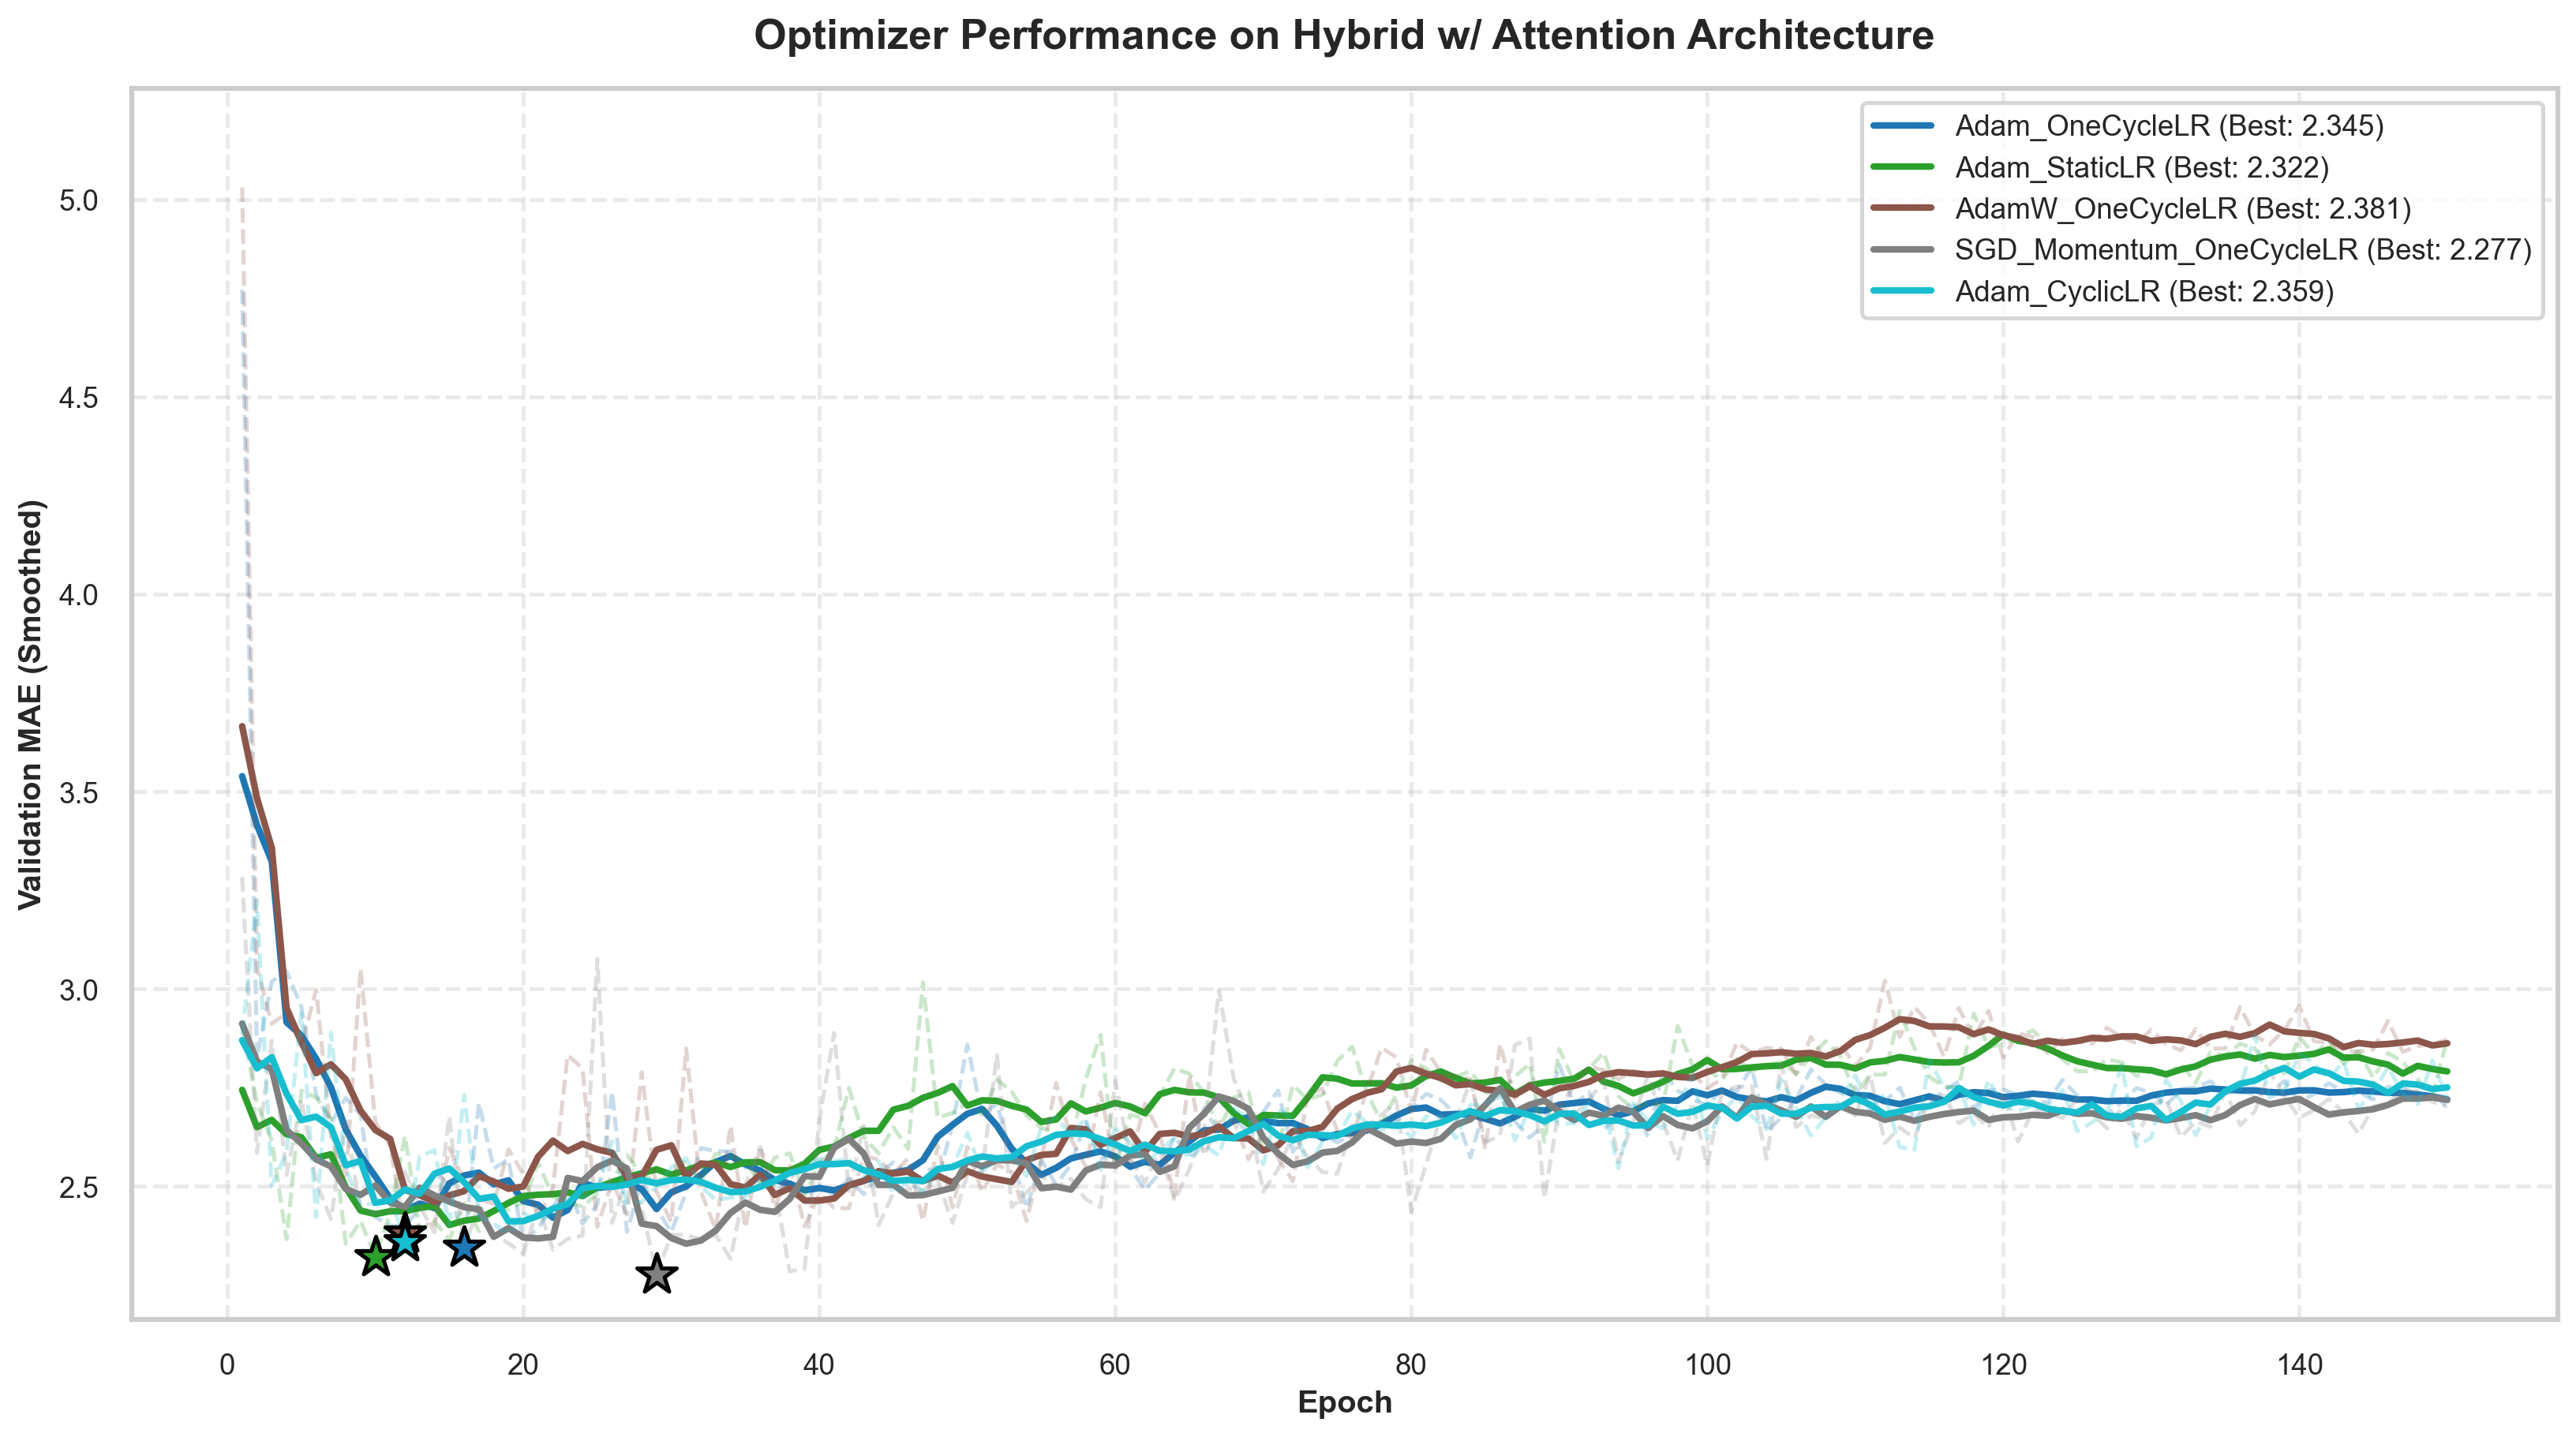


--- Plotting for: Hybrid CNN-LSTM ---


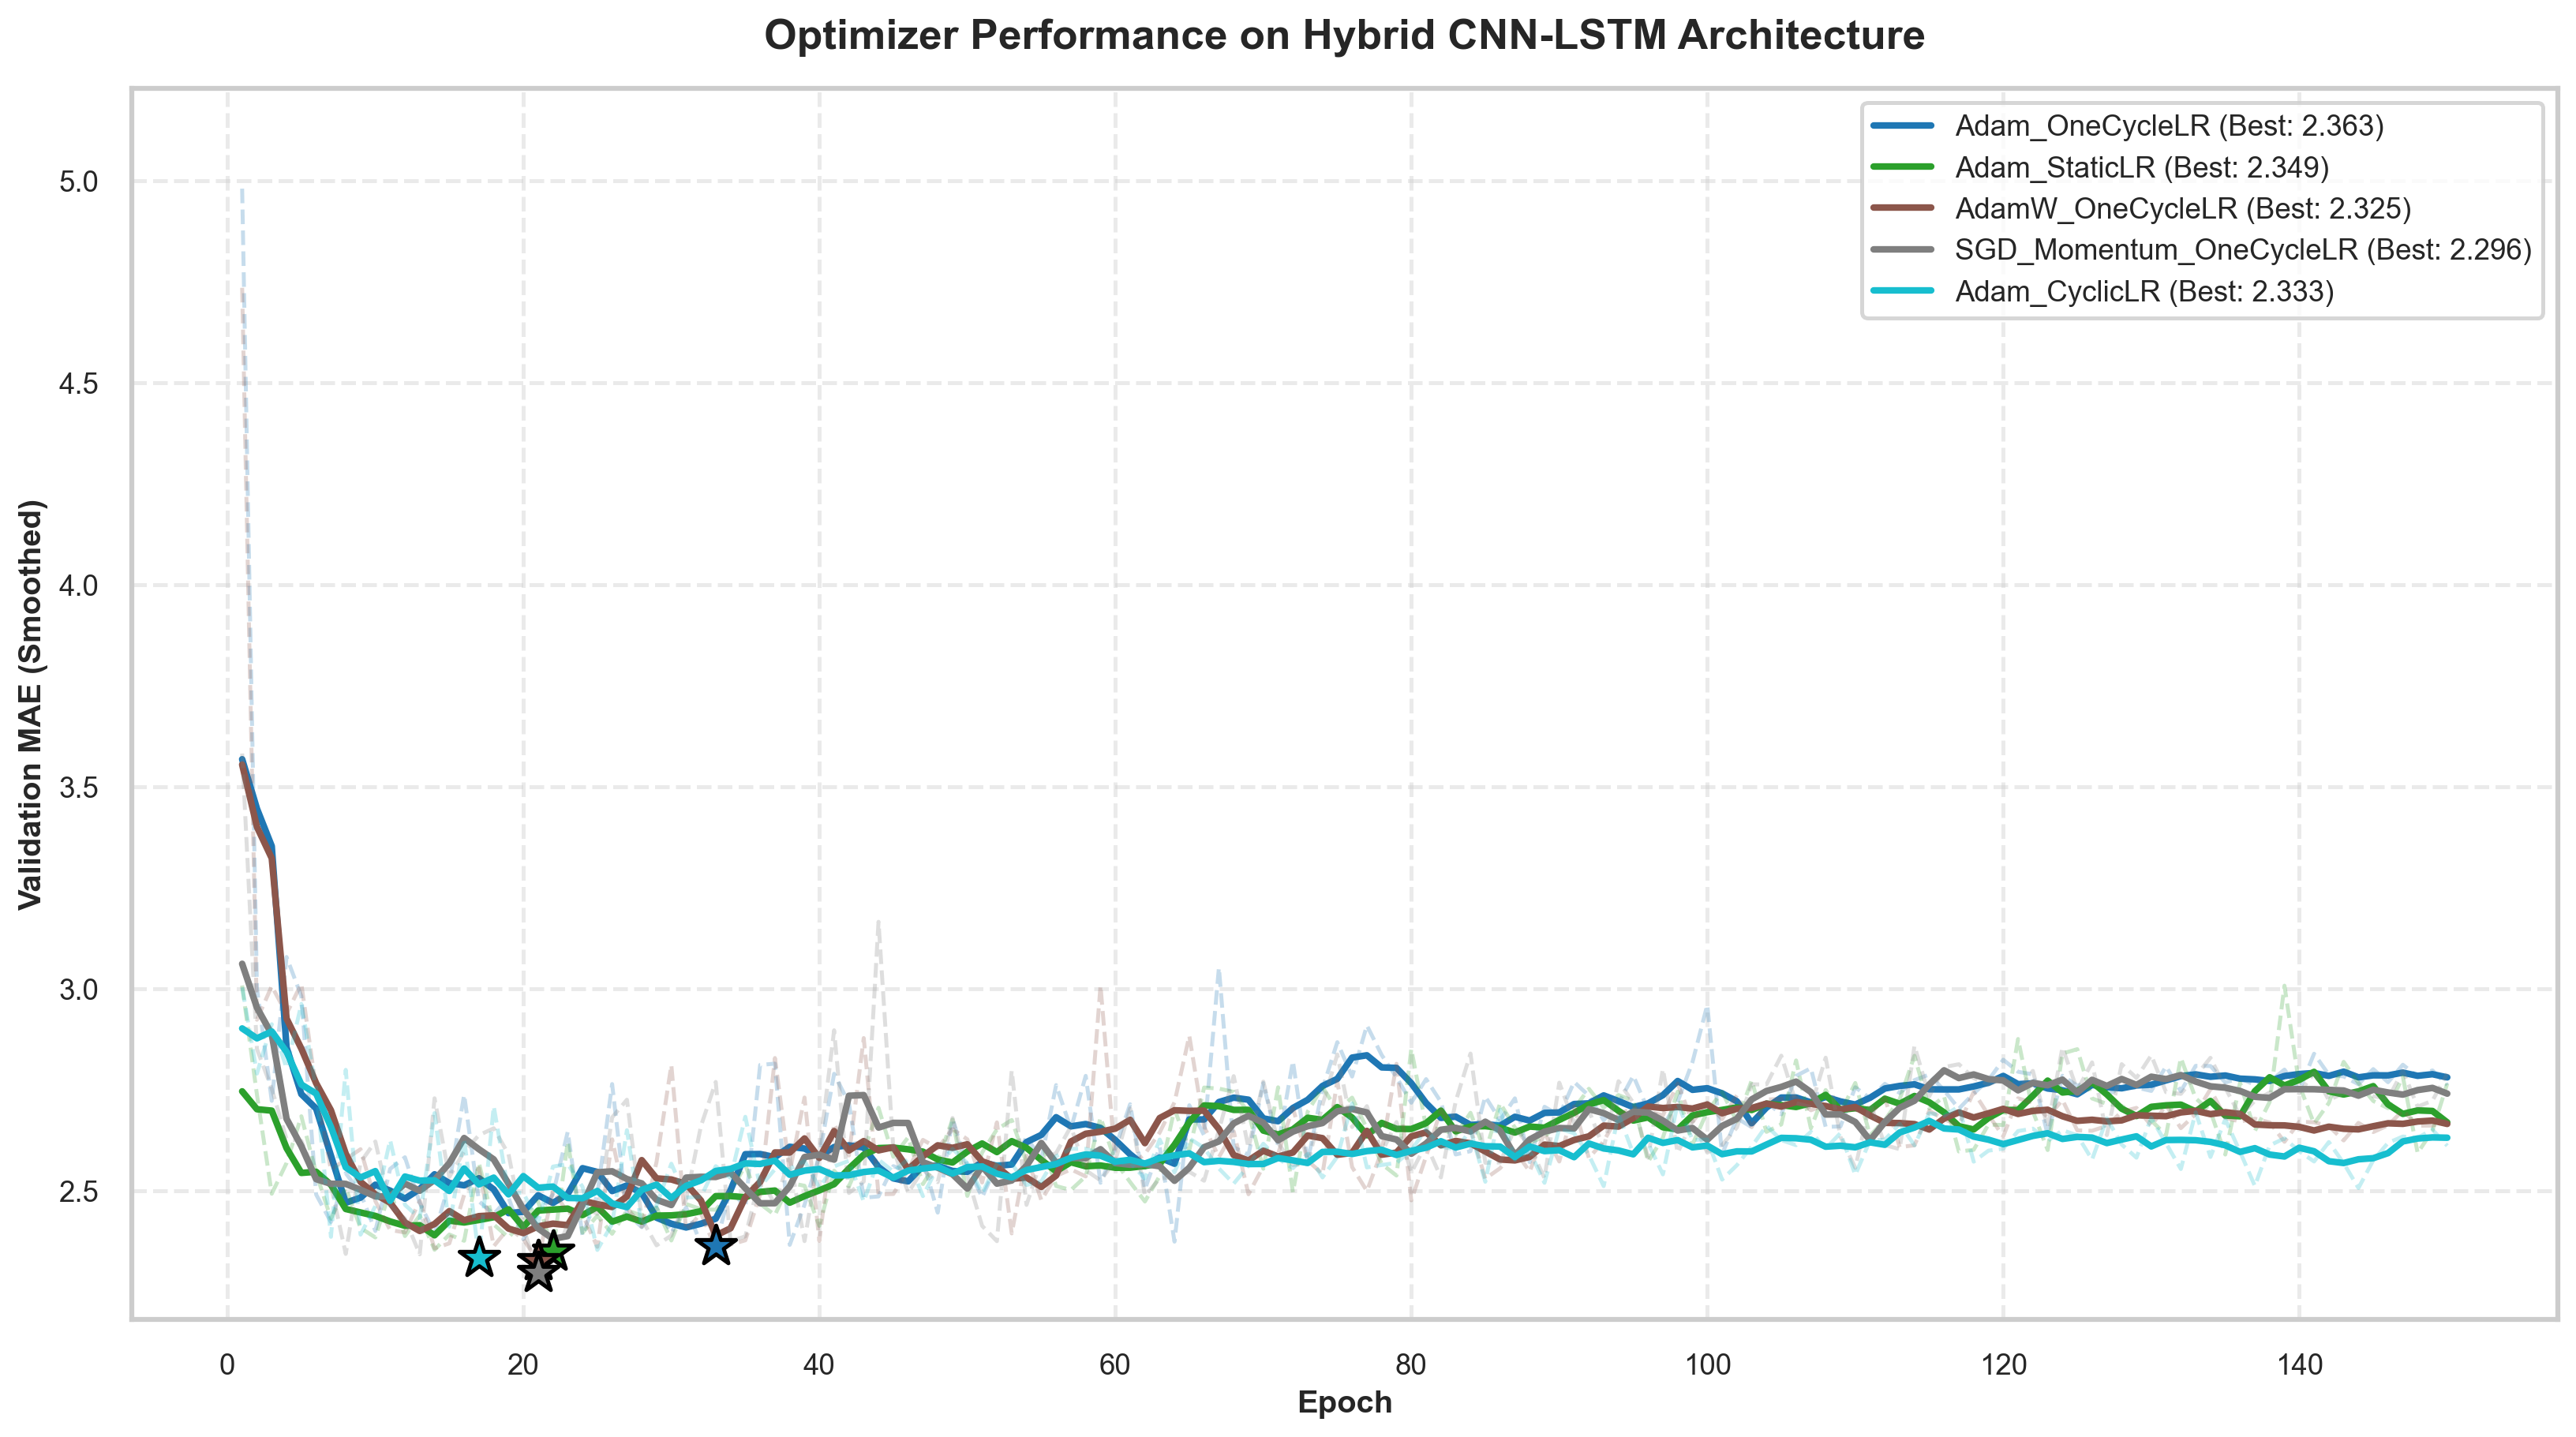


--- Plotting for: LSTM ---


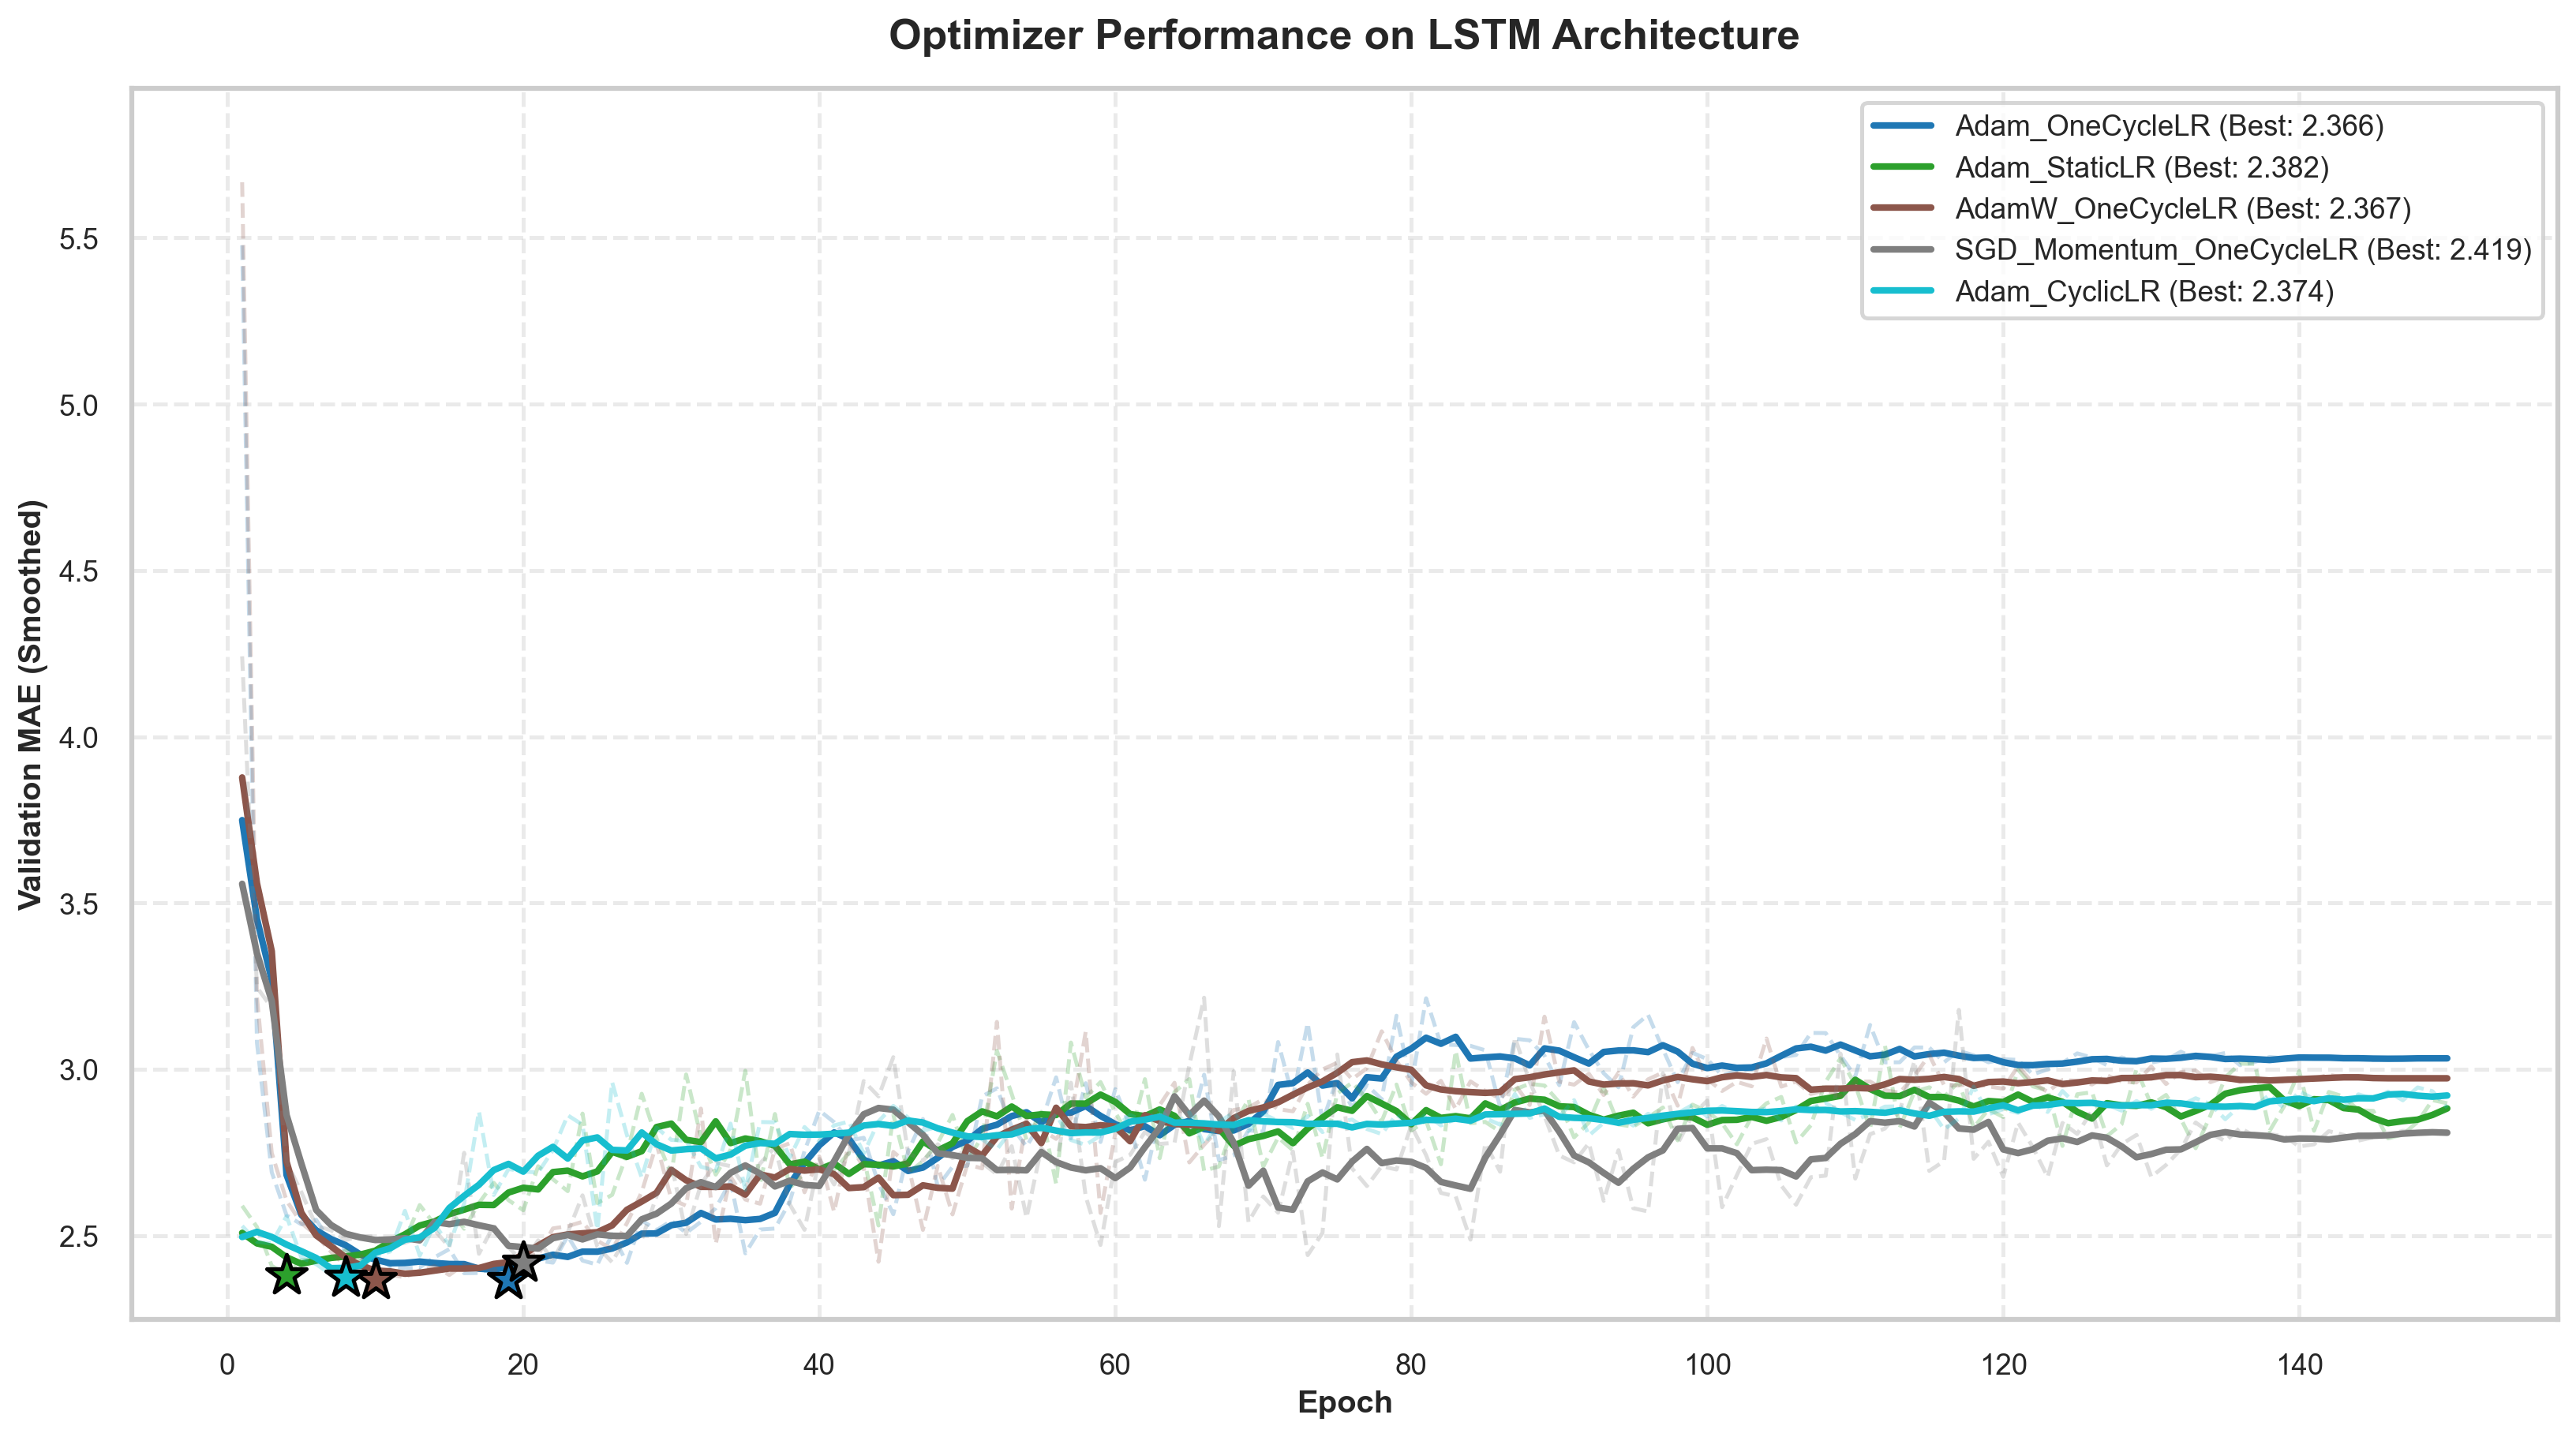


--- Plotting for: 1D CNN ---


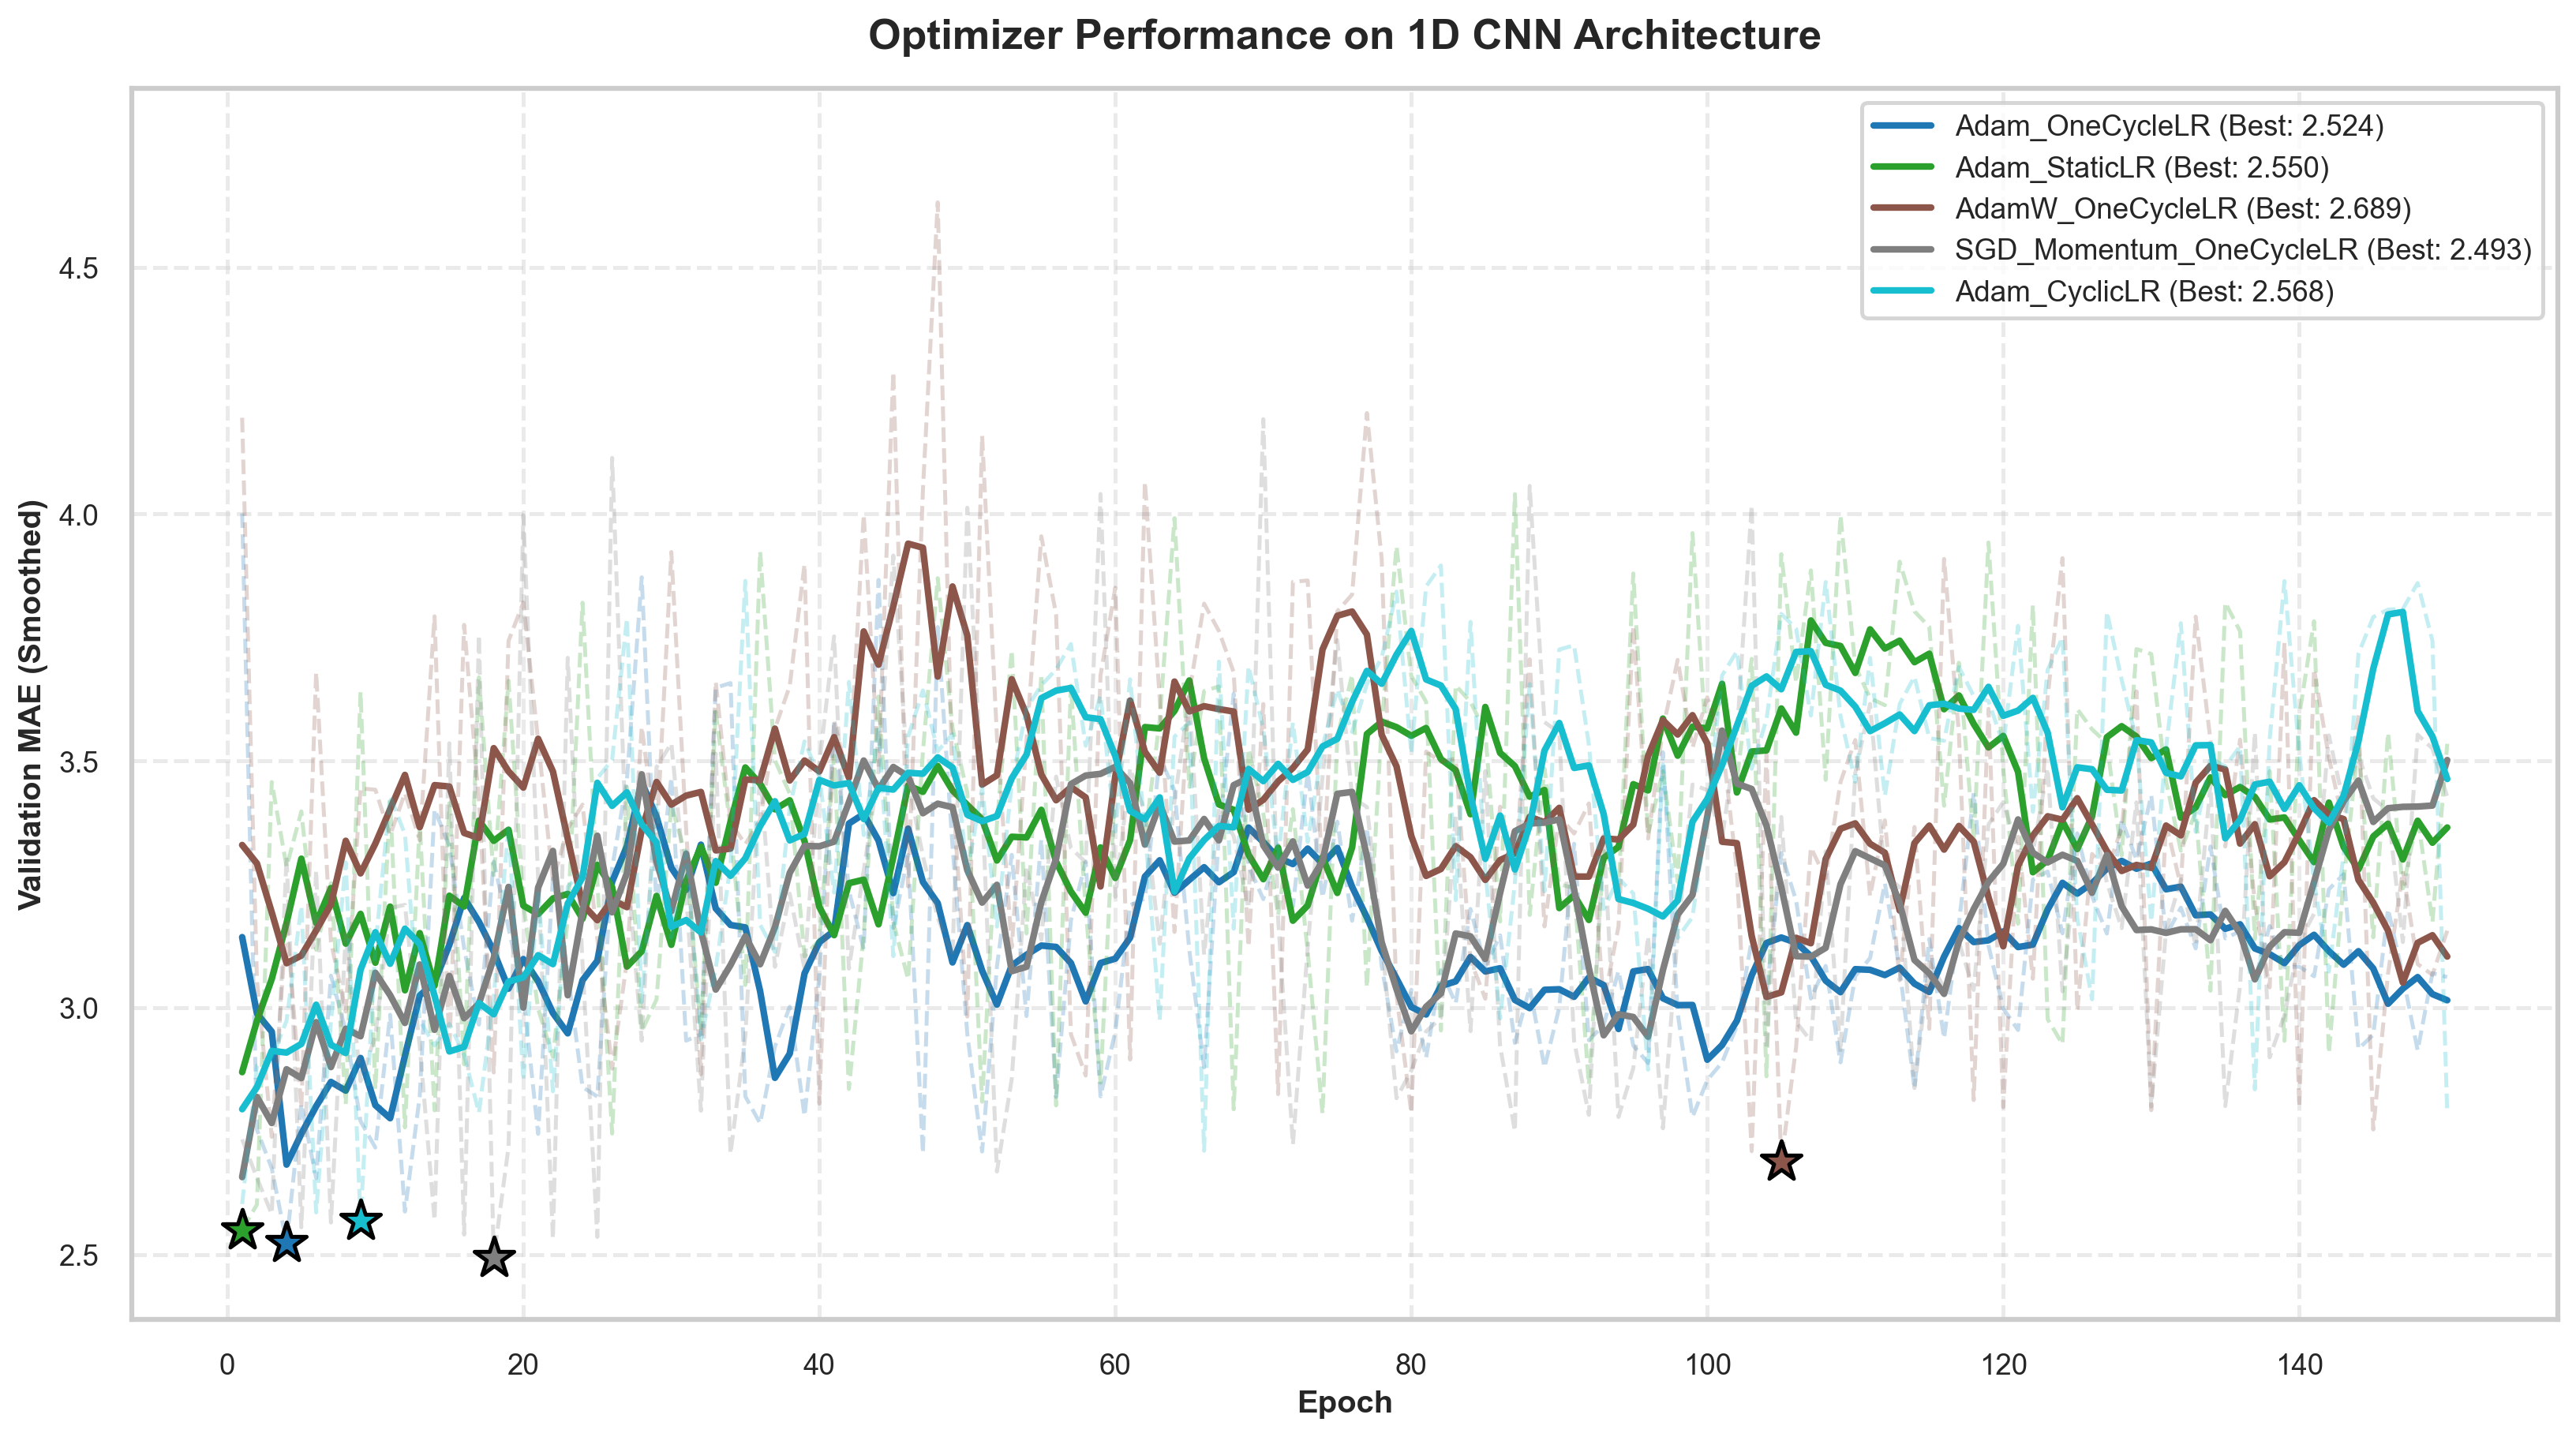


--- Plotting for: MLPER-Inspired (Image) ---


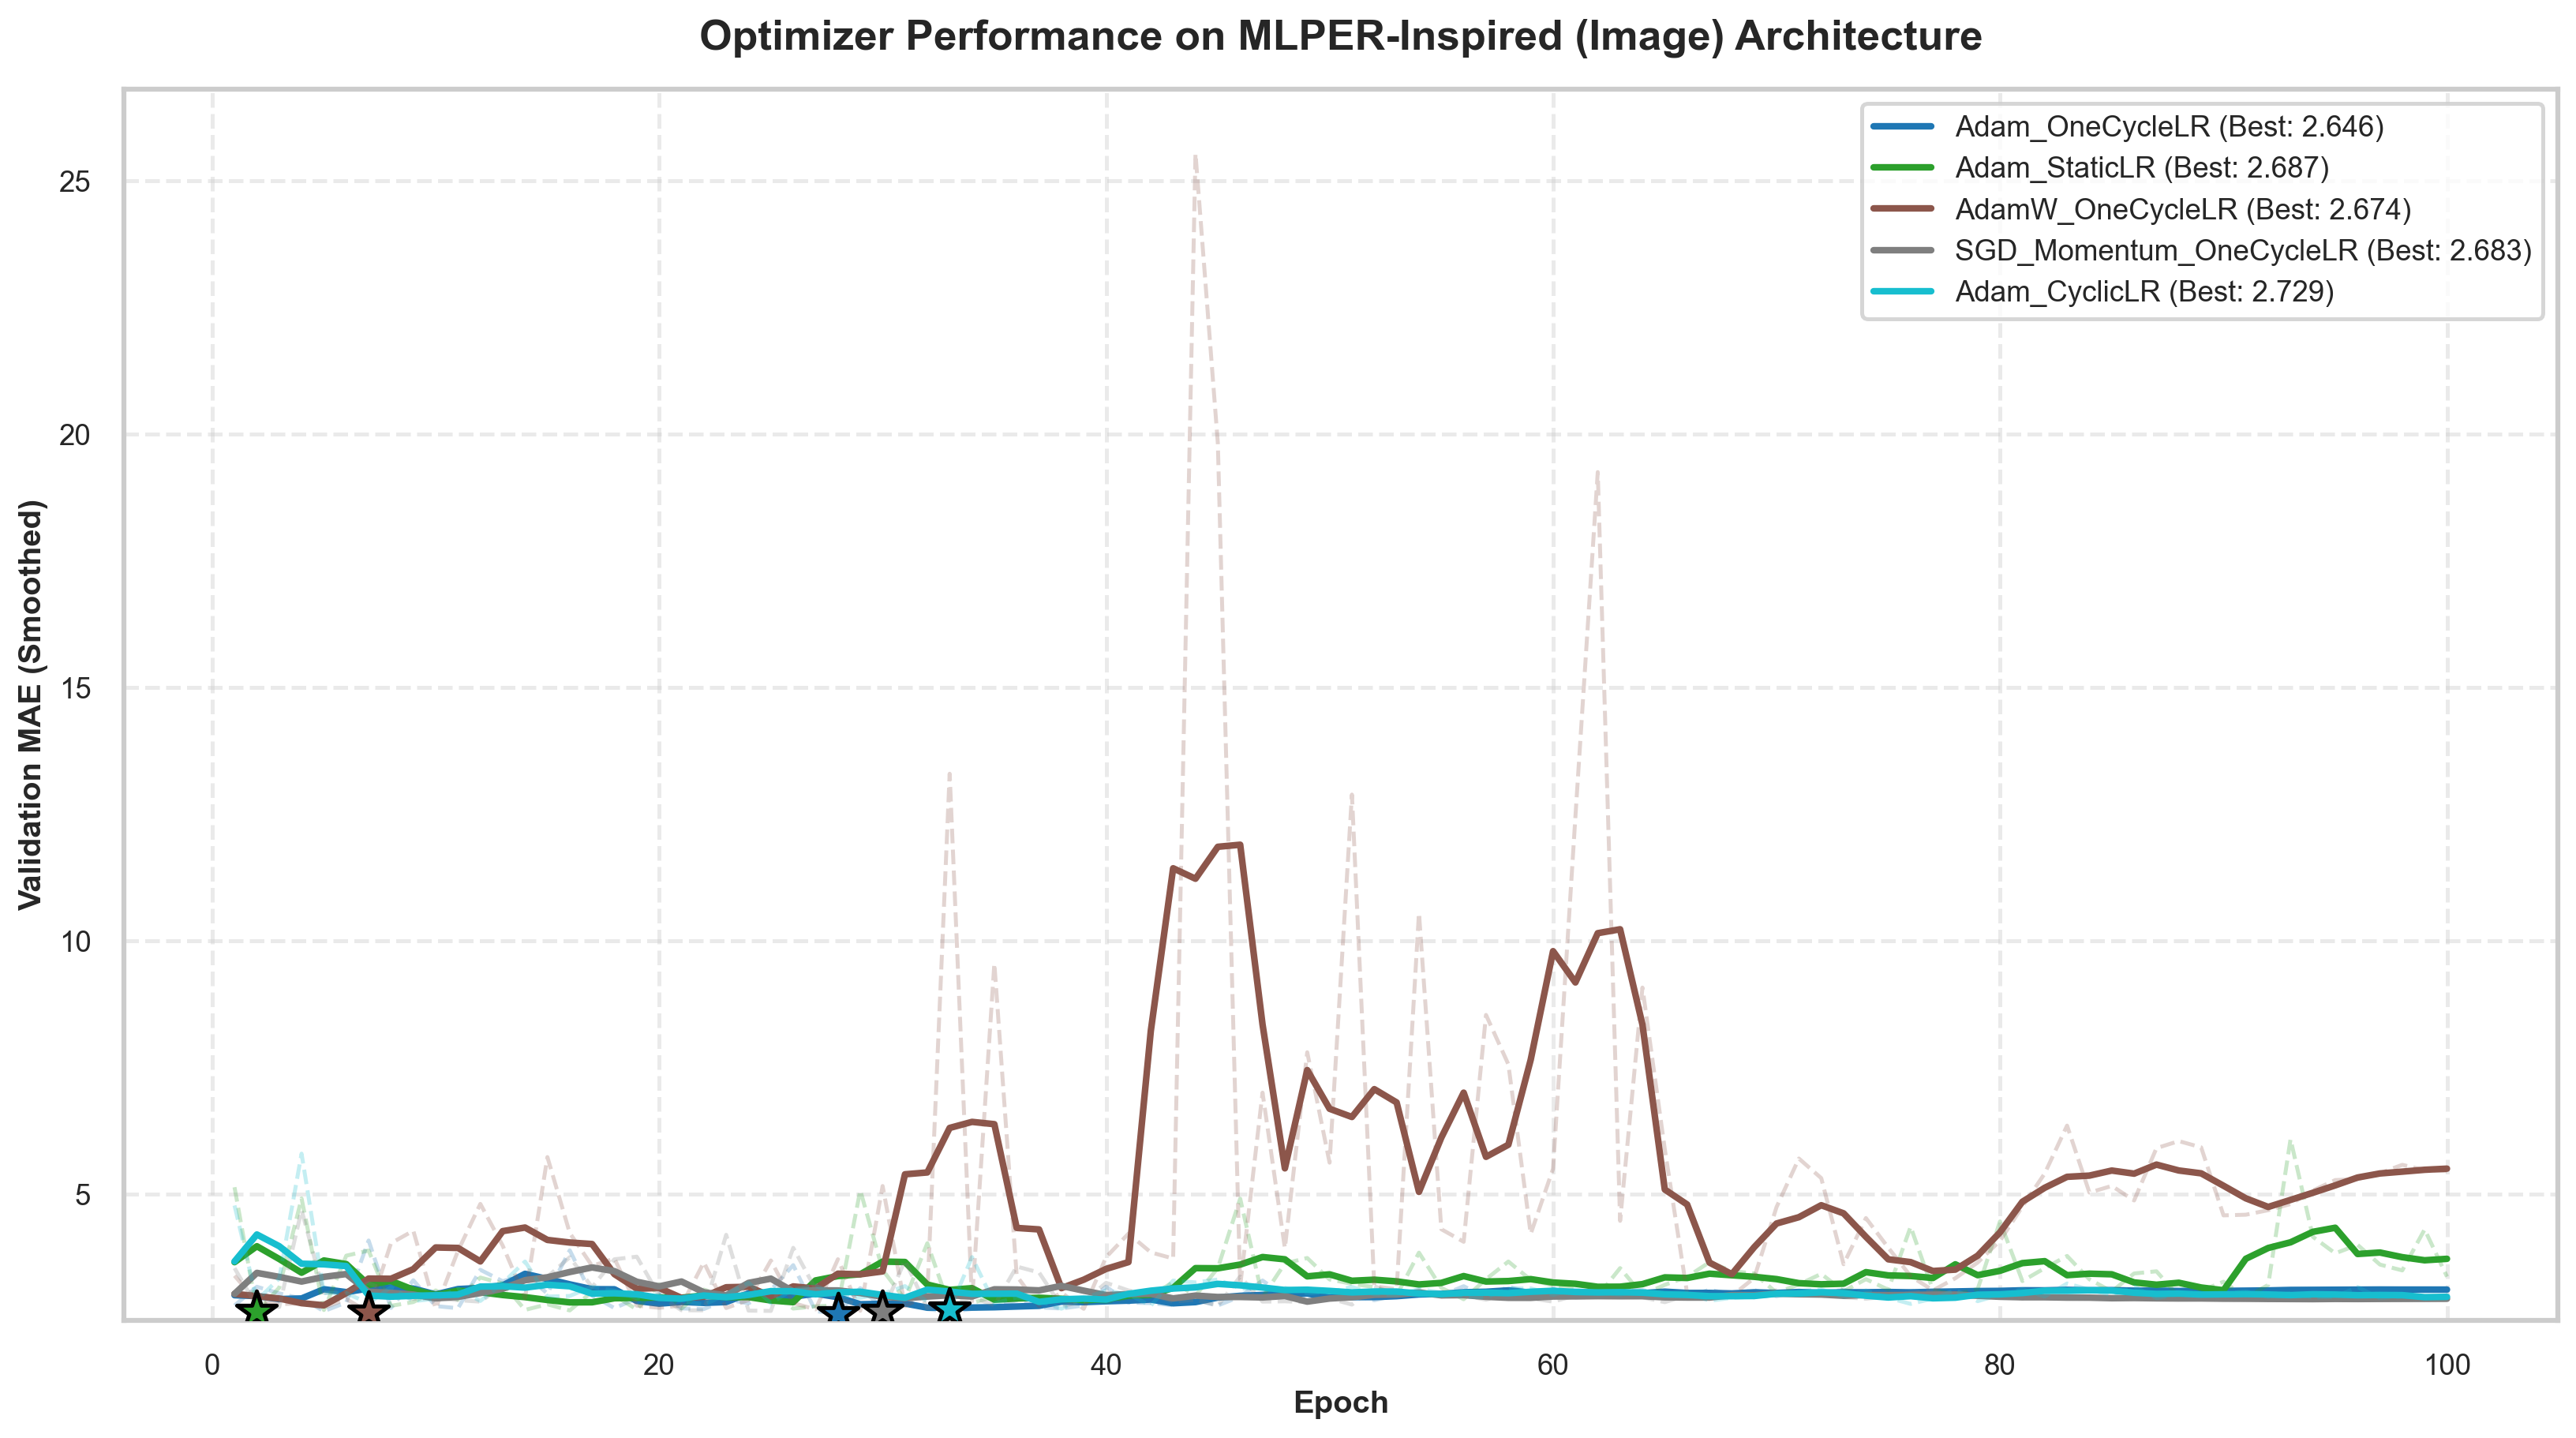

In [131]:
# Task: Generate Optimizer Performance Comparison for EACH Model Architecture (with Dynamic Y-Axis)
try:
    # Ensure histories and performers_df are loaded from the previous cell
    if 'histories' not in globals() or 'performers_df' not in globals():
        raise NameError("Run the previous cell first to load 'histories' and 'performers_df'.")
    # Get a list of all unique model names
    model_names = performers_df['Model'].unique()
    print(f"Generating optimizer comparison plots for the following models: {list(model_names)}")
    # Loop through each model and create a dedicated plot
    for model_name in model_names:
        print(f"\n--- Plotting for: {model_name} ---")
        optimizer_results = histories.get(model_name, {})
        if not optimizer_results:
            print(f"No data found for {model_name}. Skipping.")
            continue
        fig, ax = plt.subplots(figsize=(14, 8))
        colors = plt.cm.tab10(np.linspace(0, 1, len(optimizer_results)))
        window_size = 5  # Smoothing window
        # --- First, determine the dynamic Y-axis range for this model ---
        min_val_overall = float('inf')
        max_val_overall = float('-inf')
        for history in optimizer_results.values():
            if history['val_loss']: # Ensure list is not empty
                min_val_overall = min(min_val_overall, min(history['val_loss']))
                max_val_overall = max(max_val_overall, max(history['val_loss']))
        # Add 10% padding, but ensure the bottom is not negative
        y_bottom = max(0, min_val_overall * 0.95) 
        y_top = max_val_overall * 1.05
        # --- Now, plot the data ---
        for (optimizer_name, history), color in zip(optimizer_results.items(), colors):
            epochs = np.array(history['epoch'])
            val_loss = np.array(history['val_loss'])
            # 1. Plot the raw, noisy data with low opacity for context
            ax.plot(epochs, val_loss, alpha=0.25, color=color, linewidth=1.5, linestyle='--')
            # 2. Plot the smoothed trend line
            val_loss_smooth = pd.Series(val_loss).rolling(window=window_size, center=True, min_periods=1).mean()
            best_val_mae = history['best_val_mae']
            ax.plot(epochs, val_loss_smooth, label=f"{optimizer_name} (Best: {best_val_mae:.3f})", linewidth=2.5, color=color)
            # 3. Plot the star marker at the ACTUAL best epoch on the RAW data point
            best_epoch = history['best_epoch']
            ax.scatter([best_epoch], [best_val_mae], s=250, zorder=5, marker='*', edgecolors='black', linewidths=1.5, color=color)
        ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
        ax.set_ylabel('Validation MAE (Smoothed)', fontsize=12, fontweight='bold')
        ax.set_title(f'Optimizer Performance on {model_name} Architecture', fontsize=16, fontweight='bold', pad=15)
        ax.legend(fontsize=11, loc='best')
        ax.grid(True, alpha=0.4, linestyle='--')
        # Set the dynamically calculated y-axis limits
        ax.set_ylim(y_bottom, y_top) 
        plt.tight_layout()
        plt.show()
except NameError as e:
    print(f"Execution failed: {e}. Please ensure the cell in Section 4 has been run successfully.")
except Exception as e:
    print(f"An error occurred while generating optimizer comparison plots: {e}")


## 5. Detailed Error Analysis of the Best Performing Model

This section dynamically identifies the best performer from the experiment,
re-trains it for its optimal number of epochs, and generates a detailed
error analysis on the validation set.


--- Analyzing Best Performer: Hybrid w/ Attention with SGD_Momentum_OneCycleLR for 29 epochs ---

Re-training model to generate fresh predictions for analysis...
Using device: cuda (NVIDIA GeForce RTX 4070 Laptop GPU)
CUDA Version: 12.4


Epoch 1/29:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 2/29:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 3/29:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 4/29:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 5/29:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 6/29:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 7/29:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 8/29:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 9/29:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 10/29:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 11/29:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 12/29:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 13/29:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 14/29:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 15/29:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 16/29:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 17/29:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 18/29:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 19/29:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 20/29:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 21/29:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 22/29:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 23/29:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 24/29:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 25/29:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 26/29:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 27/29:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 28/29:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 29/29:   0%|          | 0/105 [00:00<?, ?it/s]

✓ Re-training complete.

Generating predictions on validation set...
Using device: cuda (NVIDIA GeForce RTX 4070 Laptop GPU)
CUDA Version: 12.4

--- Performance Metrics for Re-trained Best Model ---
Validation MAE:     2.4728 (Original experiment best was: 2.2769)
Validation RMSE:    3.2864
Validation R-squared: 0.2854


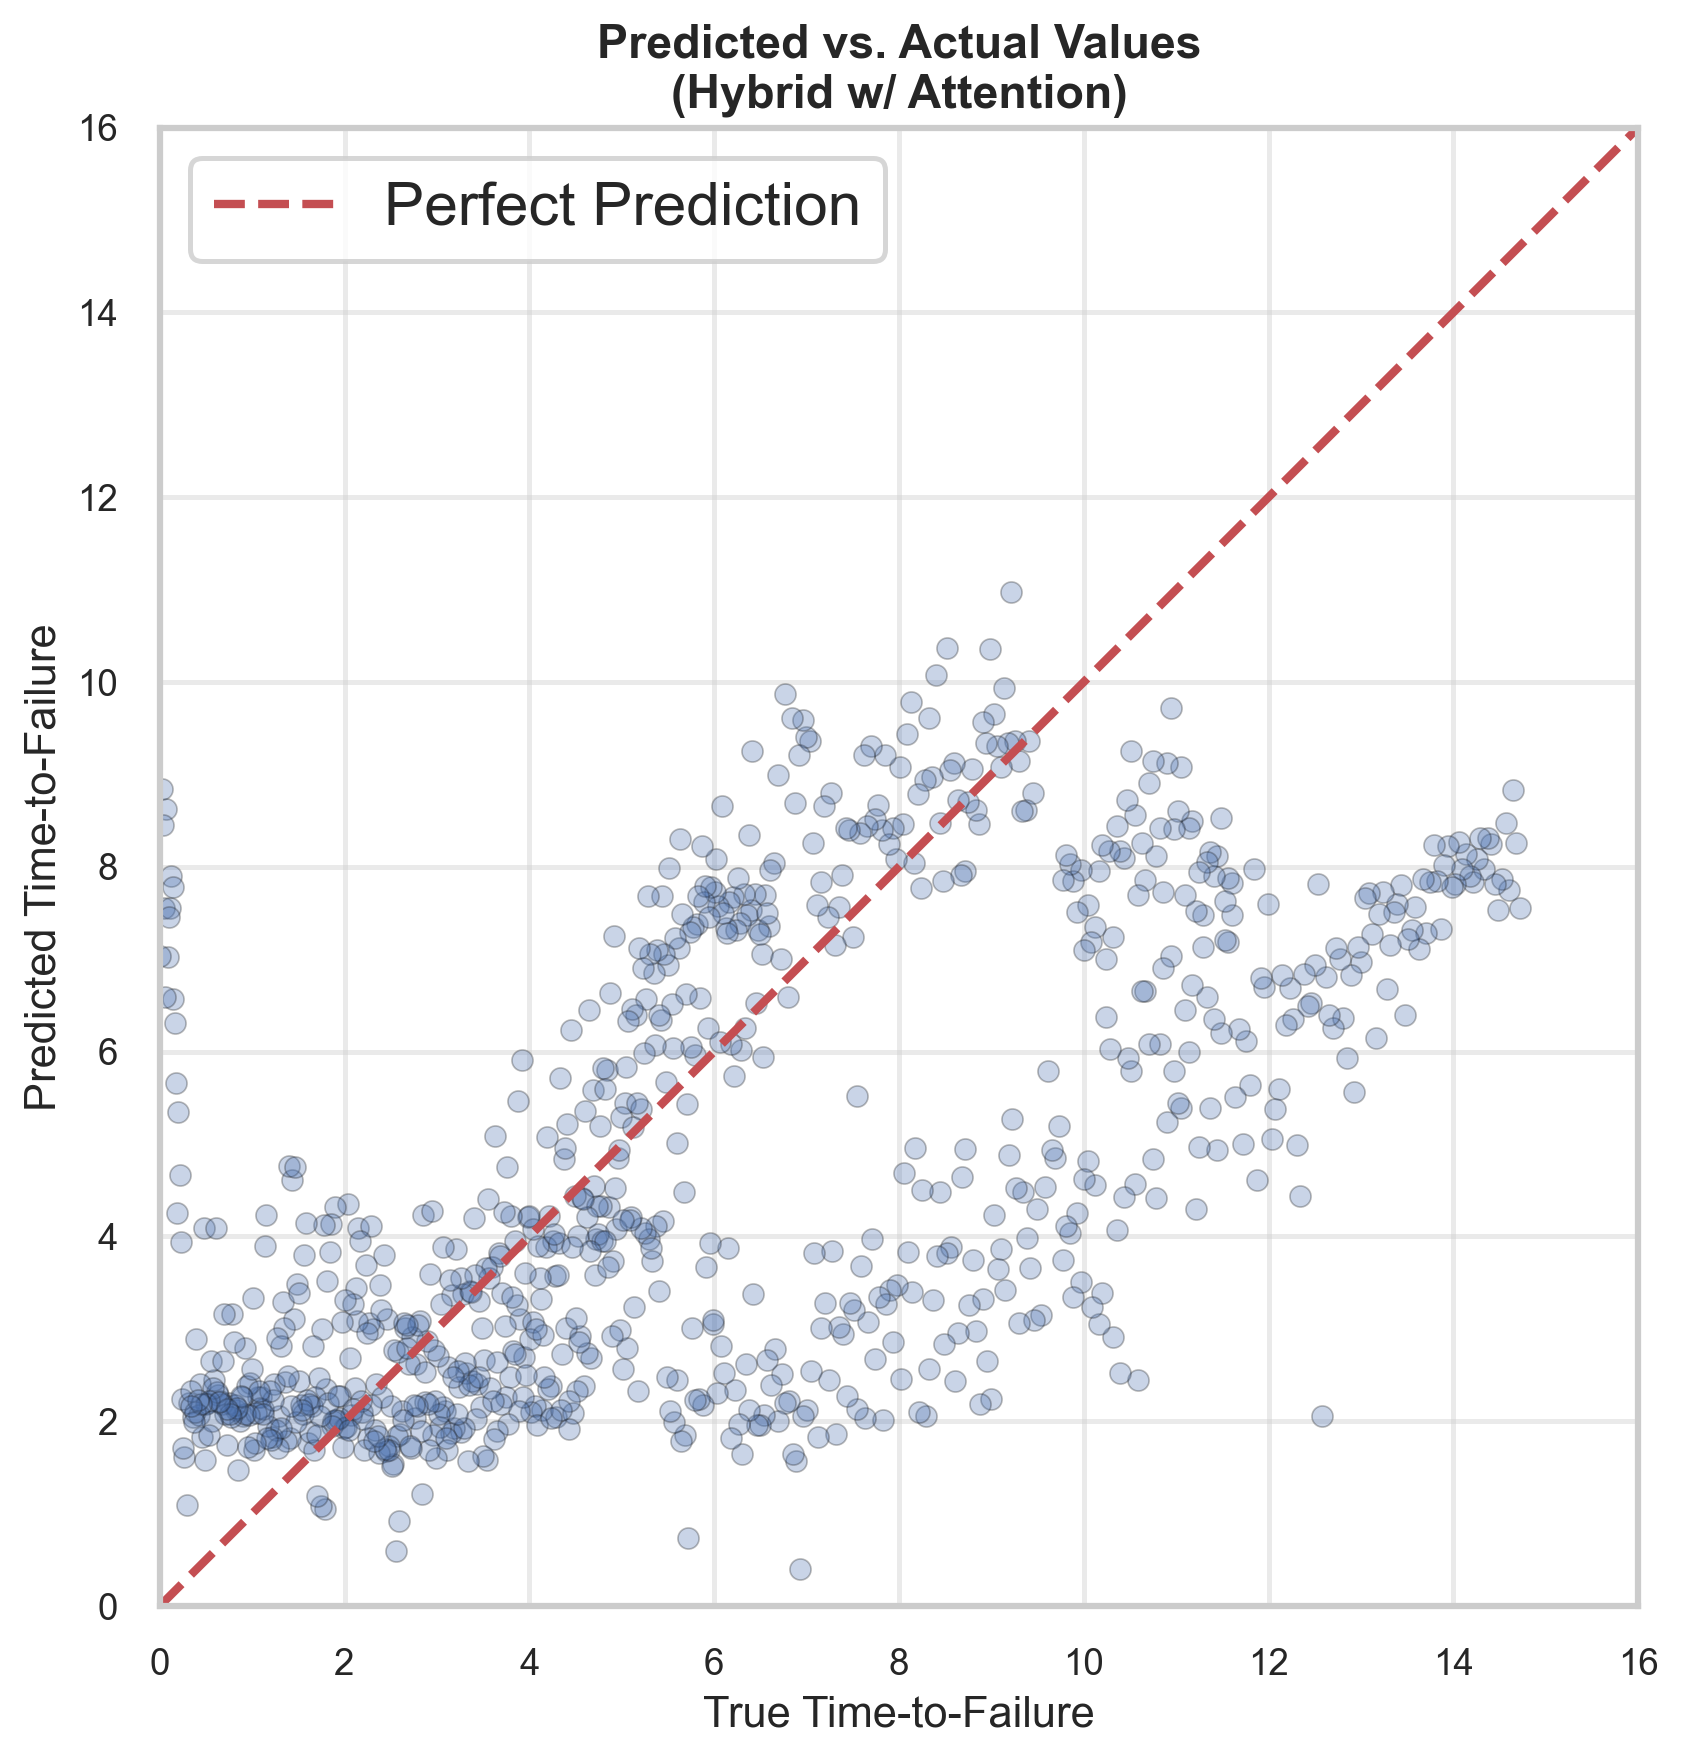

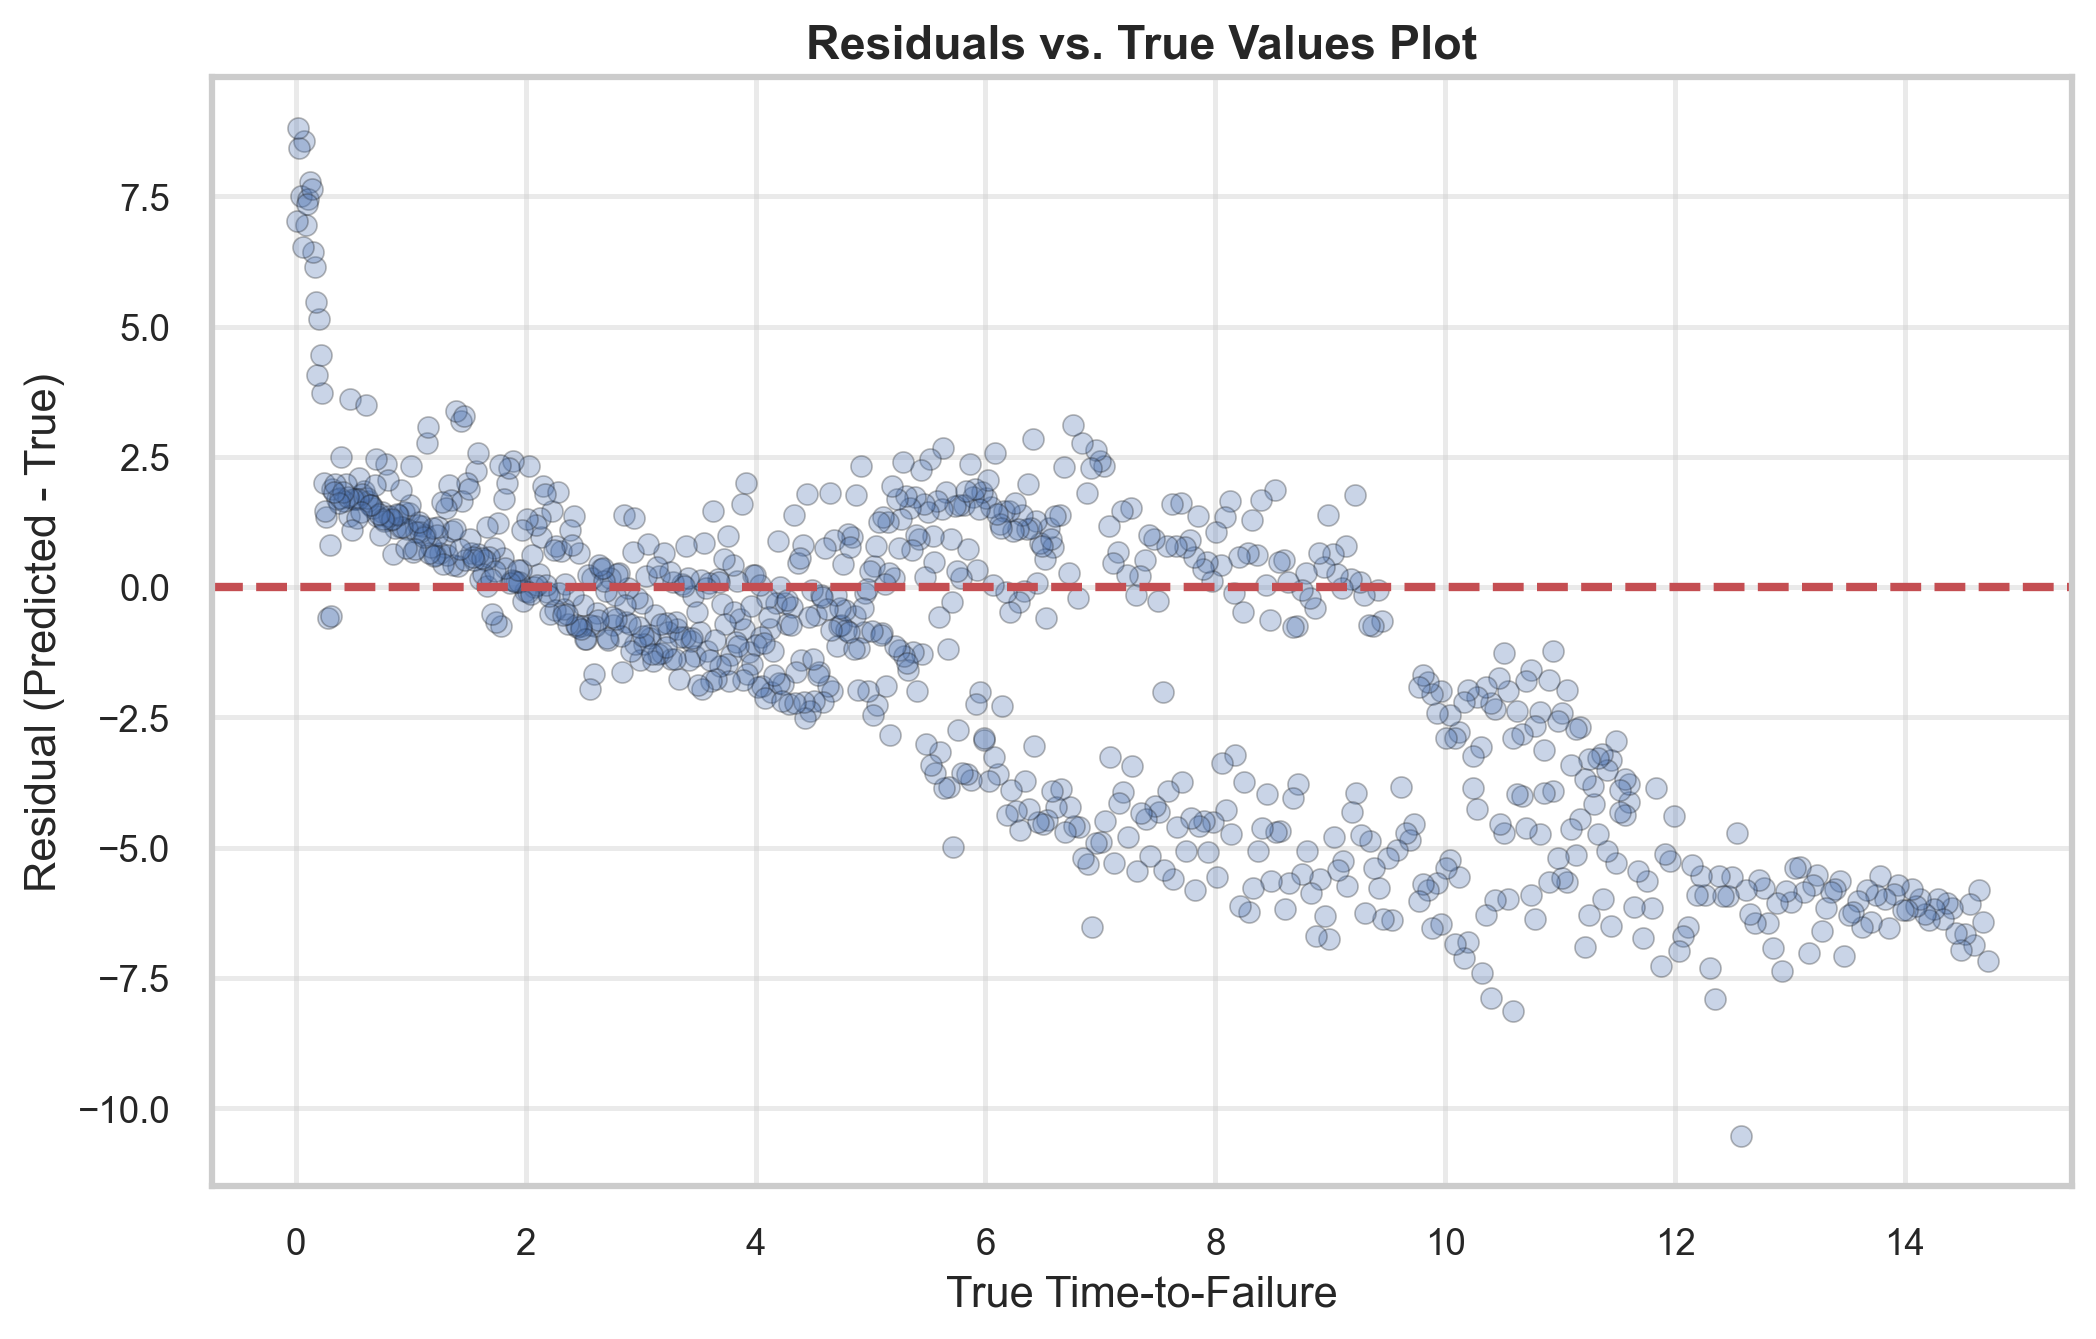

In [132]:
import config
import json
from config import OPTIMIZER_CONFIGS
import image_models
from torch.nn import L1Loss
from sklearn.metrics import mean_squared_error, r2_score

try:
    # Ensure performers_df is loaded
    if 'performers_df' not in globals() or performers_df.empty:
        raise FileNotFoundError("Run the cell in Section 4 to load performers_df.")

    best_performer = performers_df.iloc[0]
    best_model_name = best_performer['Model']
    best_optimizer_name = best_performer['Optimizer']
    best_epochs = int(best_performer['Best_Epoch'])
    
    print(f"--- Analyzing Best Performer: {best_model_name} with {best_optimizer_name} for {best_epochs} epochs ---")
    
    is_image = "Image" in best_model_name

    # --- Model, Data, and Optimizer Setup ---
    model_map = { 
        "1D CNN": models.CNNModel, "LSTM": models.LSTMModel, 
        "Hybrid CNN-LSTM": models.HybridModel, "Hybrid w/ Attention": models.HybridAttention,
        "MLPER-Inspired (Image)": image_models.MLPERRegressionModel 
    }
    ModelClass = model_map[best_model_name]
    
    # Load data
    if is_image:
        print("Image model analysis. This step will not re-train but will load a random model instance for plotting.")
        val_loader = torch.load('img_val_loader.pth', weights_only=False)
        model = ModelClass()
    else:
        train_loader = torch.load('train_loader.pth', weights_only=False)
        val_loader = torch.load('val_loader.pth', weights_only=False)
        num_features = next(iter(train_loader))[0].shape[-1]
        model = ModelClass(input_features=num_features)
    
        # Find the correct optimizer configuration
        opt_config = next((item for item in OPTIMIZER_CONFIGS if item['name'] == best_optimizer_name), None)
        if opt_config is None: raise ValueError(f"Optimizer config '{best_optimizer_name}' not found.")
        
        # --- Re-training Loop ---
        print("\nRe-training model to generate fresh predictions for analysis...")
        device = utils.get_device()
        model.to(device)
        criterion = L1Loss()
        
        optimizer_class = {'Adam': torch.optim.Adam, 'AdamW': torch.optim.AdamW, 'SGD': torch.optim.SGD}[opt_config['optimizer']]
        optimizer_kwargs = {k: v for k, v in opt_config.items() if k in ['lr', 'weight_decay', 'momentum']}
        optimizer = optimizer_class(model.parameters(), **optimizer_kwargs)
        
        for epoch in range(best_epochs):
            model.train()
            for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{best_epochs}", leave=False):
                inputs, labels = [d.to(device) for d in batch]
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        print("✓ Re-training complete.")

    # --- Prediction and Metrics ---
    print("\nGenerating predictions on validation set...")
    preds, trues = [], []
    device = utils.get_device()
    model.to(device)
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            if is_image:
                mag, phase, yb = batch
                outputs = model(mag.to(device), phase.to(device))
            else:
                Xb, yb = batch
                outputs = model(Xb.to(device))
            preds.extend(outputs.cpu().numpy().flatten())
            trues.extend(yb.numpy().flatten())
    
    arr_true, arr_pred = np.array(trues), np.array(preds)
    residuals = arr_pred - arr_true
    
    mae = np.mean(np.abs(residuals))
    rmse = np.sqrt(mean_squared_error(arr_true, arr_pred))
    r2 = r2_score(arr_true, arr_pred)
    
    print(f"\n--- Performance Metrics for Re-trained Best Model ---")
    print(f"Validation MAE:     {mae:.4f} (Original experiment best was: {best_performer['Best_Val_MAE']:.4f})")
    print(f"Validation RMSE:    {rmse:.4f}")
    print(f"Validation R-squared: {r2:.4f}")

    # --- Plotting ---
    # 1. Predicted vs. Actual
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=arr_true, y=arr_pred, alpha=0.3, s=40, edgecolor='k', linewidth=0.5)
    plt.plot([0, 16], [0, 16], 'r--', lw=2.5, label='Perfect Prediction')
    plt.xlabel('True Time-to-Failure'); plt.ylabel('Predicted Time-to-Failure')
    plt.title(f'Predicted vs. Actual Values\n({best_model_name})', fontsize=14, fontweight='bold')
    plt.legend(); plt.grid(True, alpha=0.4); plt.xlim(0, 16); plt.ylim(0, 16)
    plt.gca().set_aspect('equal')
    plt.show()
    
    # 2. Residuals vs. True Values
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=arr_true, y=residuals, alpha=0.3, s=40, edgecolor='k', linewidth=0.5)
    plt.axhline(y=0, color='r', linestyle='--', lw=2.5)
    plt.xlabel('True Time-to-Failure'); plt.ylabel('Residual (Predicted - True)')
    plt.title('Residuals vs. True Values Plot', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.4)
    plt.show()
    
except (FileNotFoundError, NameError) as e:
    print(f"Required data not found: {e}. Please run 'prepare_dataset.py' and 'experiment.py' first.")
except Exception as e:
    print(f"An error occurred during error analysis: {e}")


## 6. Conclusion

This project conducted a comprehensive optimizer comparison experiment to identify the best model-optimizer combinations for earthquake time-to-failure prediction. The experiment evaluated multiple deep learning architectures (1D CNN, LSTM, Hybrid CNN-LSTM, and Hybrid with Attention) across various optimizer configurations (Adam, AdamW, SGD with different learning rate schedules).

**Key Findings:**

1. **Optimizer Selection Matters:** Different optimizers and learning rate schedules significantly impact model performance, with some combinations achieving substantially better validation MAE than others.

2. **Model-Optimizer Synergy:** The best-performing model-optimizer combination varies, demonstrating that architecture and optimization strategy must be considered together rather than independently.

3. **Systematic Evaluation:** By training all models with all optimizer configurations and tracking validation performance, we identified the optimal combination that minimizes validation MAE.

4. **Reproducible Workflow:** The experiment results are stored in `training_histories.json`, enabling reproducible analysis and dynamic identification of the best performers without requiring re-training.

The systematic optimizer comparison approach provides a robust methodology for selecting the best model configuration for this complex time-series regression task.
